In [243]:
import astropy.io
from astropy.io import fits
from astropy.table import vstack, Table
import dust_extinction
from astropy.modeling.models import BlackBody
import astropy.units as u
from dust_extinction.parameter_averages import F19
#import astroquery
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import StringIO 
import csv
import scipy.stats as stats
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Data Files

['SPECOBJID', 'RELIABLE', 'PLATEID', 'MJD', 'FIBERID', 'PHOTOID', 'RA', 'DEC', 'PLUG_MAG', 'PRIMTARGET', 'SECTARGET', 'TARGETTYPE', 'SPECTROTYPE', 'SUBCLASS', 'Z', 'Z_ERR', 'Z_WARNING', 'V_DISP', 'V_DISP_ERR', 'SN_MEDIAN', 'E_BV_SFD', 'ZTWEAK', 'ZTWEAK_ERR', 'SPECTRO_MAG', 'KCOR_MAG', 'KCOR_MODEL_MAG', 'RELEASE']


/tmp/ipykernel_4004564/1808239061.py:26: RuntimeWarning: invalid value encountered in divide
  OIII4363SDSStruedetect = np.where(OIII4363SDSS/OIII4363errSDSS >3)[0]


1824


/home/pheretz/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pheretz/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


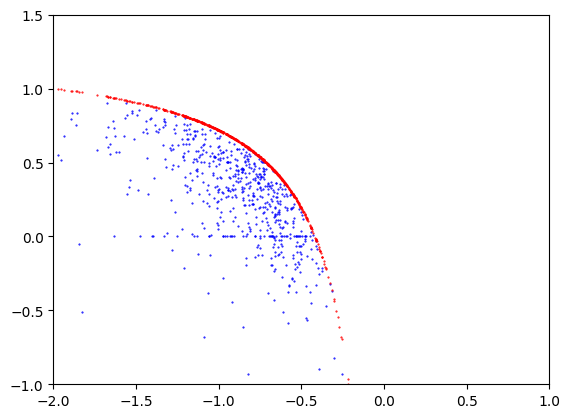

-47.89902777572917


In [271]:
# Data files

## SDSS
#SSDS galaxy data from: https://www.sdss3.org/dr8/spectro/galspec.php

#import fits data:
galSpecInfo = fits.open('~/Downloads/galSpecInfo-dr8.fits',memmap=True)
#galSpecInfo
Infocols = galSpecInfo[1].columns
Infocols.names
print(Infocols.names)
SpecInfodata = galSpecInfo[1].data
#SpecInfodata = pd.DataFrame(SpecInfodata)
#print(SpecInfodata)

galSpecLine = fits.open('~/Downloads/galSpecLine-dr8.fits',memmap=True)
Linecols = galSpecLine[1].columns
Linecols.names
#print(Linecols.names)
SDSSSpecLinedata = galSpecLine[1].data
OIII4363SDSS = SDSSSpecLinedata['OIII_4363_FLUX']
OIII4363errSDSS = SDSSSpecLinedata['OIII_4363_FLUX_ERR']
## 602,494 galaxies with detections
OIII4363SDSSdetect = np.where(OIII4363SDSS >0)[0]
## 33,202 galaxies with s/n greater than 3
OIII4363SDSStruedetect = np.where(OIII4363SDSS/OIII4363errSDSS >3)[0]
#print(len(OIII4363SDSS))
#print(len(OIII4363SDSStruedetect))

galSpecExtra = fits.open('~/Downloads/galSpecExtra-dr8.fits',memmap=True)
Linecols2 = galSpecExtra[1].columns
Linecols2.names
#print(Linecols2.names)
SDSSSpecExtradata = galSpecExtra[1].data
#SDSSSpecExtradata = pd.DataFrame(SDSSSpecExtradata)


## BATTISTI SDSS DATA
# source paper: https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.4431B/abstract

#import dat files:
BattistiSpecLine = np.genfromtxt('SDSS_DR7_sfg_lines.dat', names=True)
BattistiSpecProp = np.genfromtxt('SDSS_DR7_sfg_prop.dat', names=True)
#see column names:
#print(BattistiSpecProp.dtype.names)
#print(BattistiSpecProp[5])
#print(BattistiSpecLine.dtype.names)

## MAPPINGS
BPASS = np.genfromtxt('grid_bpass_P6.csv',names=True,delimiter=",", dtype=str)
#display(BPASS)
#BPASScols = BPASS.columns
#print(BPASS.dtype.names)

## MOSDEF!!
# corrected data, balmer lines are corrected for stellar absorption
MOSDEFlines = fits.open('linemeas_cor.fits',memmap=True)
#MOSDEFLinecols = MOSDEFlines[1].columns
#print(MOSDEFLinecols.names)
MOSDEFdata = MOSDEFlines[1].data
MOSDEFdata = pd.DataFrame(MOSDEFdata)

## MOSDEF Lines 
# recommend using the preferred flux, ** already corrected for s/n > 3**
# OIII doublet
OIII5008_MOSDEF = MOSDEFdata['OIII5008_PREFERREDFLUX']
OIII4960_MOSDEF = MOSDEFdata['OIII4960_PREFERREDFLUX']
### THIS IS THE AURORAL LINE!!! :D
OIII4364_MOSDEF = MOSDEFdata['OIII4364_PREFERREDFLUX']
OIII4364detect = np.where(OIII4364_MOSDEF >0)[0]
#print(len(OIII4364detect))
Ha_MOSDEF = MOSDEFdata['HA6565_PREFERREDFLUX']
Hb_MOSDEF = MOSDEFdata['HB4863_PREFERREDFLUX']
NII85_MOSDEF = MOSDEFdata['NII6585_PREFERREDFLUX']
NII50_MOSDEF = MOSDEFdata['NII6550_PREFERREDFLUX']

#MOSDEFdata = MOSDEFdata.loc[(OIII5008_MOSDEF>0)& (OIII4960_MOSDEF>0) &( Ha_MOSDEF >0)&(Hb_MOSDEF>0)&(NII85_MOSDEF>0)&(NII50_MOSDEF>0)]

# try to segment star-forming
#MOSDEFstarform = np.where( (OIII5008_MOSDEF>0)& (OIII4960_MOSDEF>0) &( Ha_MOSDEF >0)&(Hb_MOSDEF>0)&(NII85_MOSDEF>0)&(NII50_MOSDEF>0))
#MOSDEFstarform = MOSDEFdata.loc[(np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))>((0.61/(np.log10((NII85_MOSDEF/Ha_MOSDEF))-0.05))+1.3))]#&((NII85_MOSDEF/Ha_MOSDEF)>0)]
MOSDEFstarform = MOSDEFdata.mask(np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))>((0.61/(np.log10((NII85_MOSDEF/Ha_MOSDEF))-0.05))+1.3))
MOSDEFstarform = MOSDEFstarform.mask(np.log10((NII85_MOSDEF/Ha_MOSDEF))>0)

# uncorrected lines
OIII5008_MOSDEF = MOSDEFstarform['OIII5008_PREFERREDFLUX']
print(len(MOSDEFstarform['OIII5008_PREFERREDFLUX']))
OIII4960_MOSDEF = MOSDEFstarform['OIII4960_PREFERREDFLUX']
OIII_MOSDEF = OIII5008_MOSDEF + OIII4960_MOSDEF 
Ha_MOSDEF = MOSDEFstarform['HA6565_PREFERREDFLUX']
Hb_MOSDEF = MOSDEFstarform['HB4863_PREFERREDFLUX']
NII85_MOSDEF = MOSDEFstarform['NII6585_PREFERREDFLUX']
NII50_MOSDEF = MOSDEFstarform['NII6550_PREFERREDFLUX']
NII_MOSDEF = NII85_MOSDEF + NII50_MOSDEF
SII18_MOSDEF = MOSDEFstarform['SII6718_PREFERREDFLUX']
SII33_MOSDEF = MOSDEFstarform['SII6733_PREFERREDFLUX']
SII_MOSDEF = SII18_MOSDEF + SII33_MOSDEF

## Test what's going on w MOSDEF w a BPT
# not dust-corrected
x1 = np.log10((NII85_MOSDEF/Ha_MOSDEF))
y1 = np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))
# Kewley 2001 line:
# log(OIII/Hb) = (0.61/(log(NII/Ha)-.47))+1.19
# Kauffman line
kauffline = (0.61/(x1-0.05))+1.3

#Plot
plt.scatter(x1,y1,s=1, c='b', marker='.')
plt.scatter(x1,kauffline ,s=1, c='r', marker='.')
plt.xlim([-2,1])
plt.ylim([-1,1.5])
#plt.xlabel("Log([NII]/Halpha)")
#plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
plt.show()

#### MOSDEF STATS ####
# 1824 total galaxies
# 414 with a 4364 detection

### 3D HST for classification?
# corrected data, balmer lines are corrected for stellar absorption
HSTdata = fits.open('3dhst.v4.1.5.master.fits')#,memmap=True)
HSTdatacols = HSTdata[1].columns
#print(HSTdatacols.names)

# No agn markers. 
# Pipit suggests that I use the method from SDSS but can't find

## Redshift
# each line has a calculated redshift. Which one to use? maybe OIII 5007 because bright and isolated?
OIIz = MOSDEFdata['OII3727_Z']
OIII5008z = MOSDEFstarform['OIII5008_Z']
print (np.sum(OIII5008z)/(len(OIII5008z)))

#print(MOSDEFdata['NII6550_Z'][22])
#print(MOSDEFdata['OIII5008_Z'][22])


Dust Extinction Correction: Balmer Decrement

1.5846489977004017
0.26972287531438716
1824
5.225512617878962e+21
-3.6829466501883615e+21


/home/pheretz/.local/lib/python3.9/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


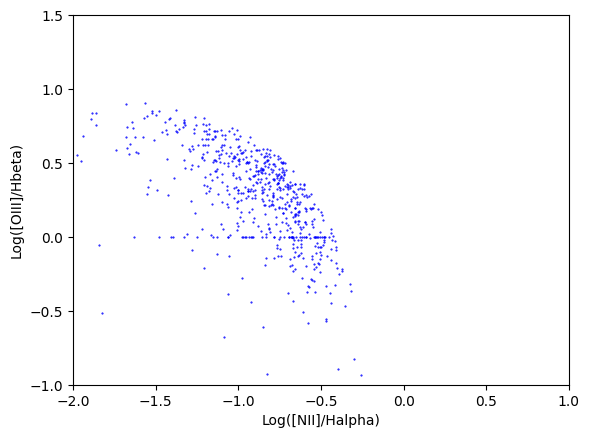

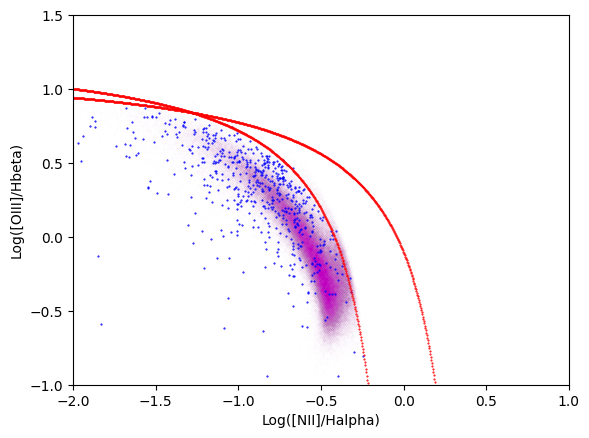

In [260]:
## Dust Extinction 

# Correcting for dust in each galaxy, based off of F19 model of MW dust extinction 
# See this doc for more information 
# https://docs.google.com/document/d/1DAK7oo5JPau576Z7sWnu0bUdTS8y4rS92MxC76ky0xQ/edit?usp=sharing

# Battisti data values, uncorrected
OIII5007_Batt = BattistiSpecLine['OIII_5007']
OIII4959_Batt = BattistiSpecLine['OIII_4959']
OIII_Batt = BattistiSpecLine['OIII_5007'] + BattistiSpecLine['OIII_4959']
Hbeta_Batt = BattistiSpecLine['Hb']
NII48_Batt = BattistiSpecLine['NII_6548']
NII84_Batt = BattistiSpecLine['NII_6584']
NII_Batt = NII48_Batt + NII84_Batt
Halpha_Batt = BattistiSpecLine['Ha']
SII17_Batt = BattistiSpecLine['SII_6717']
SII31_Batt = BattistiSpecLine['SII_6731']
SII_Batt = BattistiSpecLine['SII_6717'] + BattistiSpecLine['SII_6731']
OII26_Batt = BattistiSpecLine['OII_3726']
OII29_Batt = BattistiSpecLine['OII_3729']
OII_Batt = BattistiSpecLine['OII_3726'] + BattistiSpecLine['OII_3729']

# Observed Ha/Hb ratio
Ha_Hb_obs = Halpha_Batt / Hbeta_Batt
# Intrinsic Ha/Hb ratio value, given to me by Andrew Battisti
Ha_Hb_int = 2.86

int_obs = Ha_Hb_int / Ha_Hb_obs
int_obsavg = np.sum(int_obs)/len(int_obs)
int_obs_max = np.max(int_obs)
int_obs_min = np.min(int_obs)
#print(int_obsavg)
print(int_obs_max)
print(int_obs_min)

# k values for each line in question
ext = F19(Rv=3.1)
# units in parentheses are: 1/wavelength(um) units 
# and we will assume Rv=3.1, which is the avg MW value.
k_Hb = ext(1/.48613)*3.1
k_Ha = ext(1/.65628)*3.1
#print(k_Ha) #looks good
#print(k_Hb) #looks good
k_OIII5007 = ext(1/.5007)*3.1
k_OIII4959 = ext(1/.4959)*3.1
k_NII84 = ext(1/.6584)*3.1
k_NII48 = ext(1/.6548)*3.1
k_SII17 = ext(1/.6717)*3.1
k_SII31 = ext(1/.6731)*3.1
k_OII26 = ext(1/.3726)*3.1
k_OII29 = ext(1/.3729)*3.1

## Color correction, E(B-V) = log10 ( (Ha/Hb)obs / (Ha/Hb)int ) / (0.4(k(Hb) - (k(Ha))))
EB_V = np.log10( Ha_Hb_obs / Ha_Hb_int ) / (0.4*(k_Hb - k_Ha))
#print(EB_V[44]) # looks good, Andrew says should be less than 0.9
#print(max(EB_V))
#print(min(EB_V))
#print(np.sum(EB_V)/len(EB_V))

## Intrinsic flux, accounting for attenuation, Fint = Fatt * 10^ (0.4*k(lambda)*EB_V)
#Halpha_Batt_int = (pow(10,0.4*k_Ha*EB_V))*Halpha_Batt #10**(0.4*k_Ha*EB_V))
x = (pow(10,0.4*k_Ha*EB_V)) 
Halpha_Batt_int = x*Halpha_Batt
#cleanedList = [x for x in Halpha_Batt_int if (np.isnan(x) == False)]
#print(cleanedList)
Hbeta_Batt_int = (pow(10,0.4*k_Hb*EB_V))*Hbeta_Batt
OIII5007_Batt_int = (pow(10,0.4*k_OIII5007*EB_V))*OIII5007_Batt
OIII4959Batt_int = (pow(10,0.4*k_OIII4959*EB_V))*OIII4959_Batt
OIII_Batt_int = OIII5007_Batt_int + OIII4959Batt_int
NII84_Batt_int = (pow(10,0.4*k_NII84*EB_V))*NII84_Batt
NII48_Batt_int = (pow(10,0.4*k_NII48*EB_V))*NII48_Batt
NII_Batt_int = NII84_Batt_int + NII48_Batt_int
SII17_Batt_int = (pow(10,0.4*k_SII17*EB_V))*SII17_Batt
SII31_Batt_int = (pow(10,0.4*k_SII31*EB_V))*SII31_Batt
SII_Batt_int = SII17_Batt_int + SII31_Batt_int
OII26_Batt_int = (pow(10,0.4*k_OII26*EB_V))*OII26_Batt
OII29_Batt_int = (pow(10,0.4*k_OII29*EB_V))*OII29_Batt
OII_Batt_int = OII26_Batt_int + OII29_Batt_int

# check out averages to see if working correctly.
# avg around 2, looks good
Haratio = Halpha_Batt_int/Halpha_Batt
Haavg = np.sum(Haratio)/len(Haratio)
#print(Haavg)
Hbratio = Hbeta_Batt_int/Hbeta_Batt
Hbavg = np.sum(Hbratio)/len(Hbratio)
#print(Hbavg)
OIIIratio = OIII5007_Batt_int/OIII5007_Batt
OIIIavg = np.sum(OIIIratio)/len(OIIIratio)
#print(OIIIavg)
NII84ratio = NII84_Batt_int/NII84_Batt
NII84avg = np.sum(NII84ratio)/len(NII84ratio)
#print(NII84avg)

## BPT diagram for sanity check
# Should just be star forming branch
# Dust is canceled in BPT ratios, so should look same
# Looks great!

# dust-corrected
x = np.log10((NII84_Batt_int/Halpha_Batt_int))
y = np.log10((OIII_Batt_int/Hbeta_Batt_int))

# not dust-corrected
x1 = np.log10((NII84_Batt/Halpha_Batt))
y1 = np.log10((OIII_Batt/Hbeta_Batt))


### MOSDEF Dust correction

# uncorrected lines
OIII5008_MOSDEF = MOSDEFstarform['OIII5008_PREFERREDFLUX']
print(len(MOSDEFstarform['OIII5008_PREFERREDFLUX']))
OIII4960_MOSDEF = MOSDEFstarform['OIII4960_PREFERREDFLUX']
OIII_MOSDEF = OIII5008_MOSDEF + OIII4960_MOSDEF 
Ha_MOSDEF = MOSDEFstarform['HA6565_PREFERREDFLUX']
Hb_MOSDEF = MOSDEFstarform['HB4863_PREFERREDFLUX']
NII85_MOSDEF = MOSDEFstarform['NII6585_PREFERREDFLUX']
NII50_MOSDEF = MOSDEFstarform['NII6550_PREFERREDFLUX']
NII_MOSDEF = NII85_MOSDEF + NII50_MOSDEF
SII18_MOSDEF = MOSDEFstarform['SII6718_PREFERREDFLUX']
SII33_MOSDEF = MOSDEFstarform['SII6733_PREFERREDFLUX']
SII_MOSDEF = SII18_MOSDEF + SII33_MOSDEF

# Observed Ha/Hb ratio
Ha_Hb_obs_MOSDEF = Ha_MOSDEF / Hb_MOSDEF
# Intrinsic Ha/Hb ratio value, given to me by Andrew Battisti
Ha_Hb_int = 2.86

int_obs_MOSDEF = Ha_Hb_int / Ha_Hb_obs_MOSDEF
int_obsavg_MOSDEF = np.sum(int_obs_MOSDEF)/len(int_obs_MOSDEF)
int_obs_max = np.max(int_obs_MOSDEF)
int_obs_min = np.min(int_obs_MOSDEF)
#print(int_obsavg_MOSDEF)
print(int_obs_max)
print(int_obs_min)

# k values for each line in question
ext = F19(Rv=3.1)
# units in parentheses are: 1/wavelength(um) units 
# and we will assume Rv=3.1, which is the avg MW value.
k_Hb = ext(1/.48613)*3.1
k_Ha = ext(1/.65628)*3.1
#print(k_Ha) #looks good
#print(k_Hb) #looks good
k_OIII5007 = ext(1/.5007)*3.1
k_OIII4959 = ext(1/.4959)*3.1
k_NII85 = ext(1/.6584)*3.1
k_NII50 = ext(1/.6584)*3.1

## Color correction, E(B-V) = log10 ( (Ha/Hb)obs / (Ha/Hb)int ) / (0.4(k(Hb) - (k(Ha))))
EB_V_MOS = np.log10( Ha_Hb_obs_MOSDEF / Ha_Hb_int ) / (0.4*(k_Hb - k_Ha))

## Intrinsic flux, accounting for attenuation, Fint = Fatt * 10^ (0.4*k(lambda)*EB_V)
x = (pow(10,0.4*k_Ha*EB_V_MOS)) 
Halpha_MOS_int = x*Ha_MOSDEF
Hbeta_MOS_int = (pow(10,0.4*k_Hb*EB_V_MOS))*Hb_MOSDEF
OIII5008_MOS_int = (pow(10,0.4*k_OIII5007*EB_V_MOS))*OIII5008_MOSDEF
OIII4960_MOS_int = (pow(10,0.4*k_OIII4959*EB_V_MOS))*OIII4960_MOSDEF
NII85_MOS_int = (pow(10,0.4*k_NII85*EB_V_MOS))*NII85_MOSDEF 
NII50_MOS_int = (pow(10,0.4*k_NII50*EB_V_MOS))*NII50_MOSDEF 
NII_MOS_int = NII85_MOS_int + NII50_MOS_int
OIII_MOS_int = OIII5008_MOS_int + OIII4960_MOS_int

## Test what's going on w MOSDEF w a BPT
# not dust-corrected
x1 = np.log10((NII85_MOSDEF/Ha_MOSDEF))
y1 = np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))
#Plot
plt.scatter(x1,y1,s=1, c='b', marker='.')
plt.xlim([-2,1])
plt.ylim([-1,1.5])
plt.xlabel("Log([NII]/Halpha)")
plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
plt.show()

# Kewley 2001 line:
# log(OIII/Hb) = (0.61/(log(NII/Ha)-.47))+1.19
xt = np.linspace(-2,1,1000)
kewline = (0.61/(xt-0.47))+1.19
# Kauffmann 2003 line:
# log([O III ]/Hβ) > 0.61/{log([N II ]/Hα) − 0.05} + 1.3.
kauffline = (0.61/(xt-0.05))+1.3

# dust-corrected
x2 = np.log10((NII85_MOS_int/Halpha_MOS_int))
y2 = np.log10((OIII5008_MOS_int /Hbeta_MOS_int ))

# SDSS dust-corrected
x = np.log10((NII84_Batt_int/Halpha_Batt_int))
y = np.log10((OIII_Batt_int/Hbeta_Batt_int))

#Plot
plt.scatter(x,y,s=.0001, c='m', marker='.')
plt.scatter(x2,y2,s=1, c='b', marker='.')
plt.scatter(xt,kewline,s=1, c='r', marker='.')
plt.scatter(xt,kauffline,s=1, c='r', marker='.')
plt.xlim([-2,1])
plt.ylim([-1,1.5])
plt.xlabel("Log([NII]/Halpha)")
plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
plt.show()



Comparing Metallicity Methods

/tmp/ipykernel_4004564/2997042763.py:12: RuntimeWarning: divide by zero encountered in divide
  y = (np.log10(NII84_Batt_int/ SII_Batt_int)) + (0.264*np.log(NII84_Batt_int/Halpha_Batt_int))
/tmp/ipykernel_4004564/2997042763.py:12: RuntimeWarning: invalid value encountered in log10
  y = (np.log10(NII84_Batt_int/ SII_Batt_int)) + (0.264*np.log(NII84_Batt_int/Halpha_Batt_int))
/tmp/ipykernel_4004564/2997042763.py:15: RuntimeWarning: divide by zero encountered in divide
  y1 = (np.log10(NII84_Batt/ SII_Batt)) + (0.264*np.log(NII84_Batt/Halpha_Batt))
/tmp/ipykernel_4004564/2997042763.py:15: RuntimeWarning: invalid value encountered in log10
  y1 = (np.log10(NII84_Batt/ SII_Batt)) + (0.264*np.log(NII84_Batt/Halpha_Batt))
/home/pheretz/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4004564/2997042763.py:60: RuntimeWarning: divide by zero encountered in divide

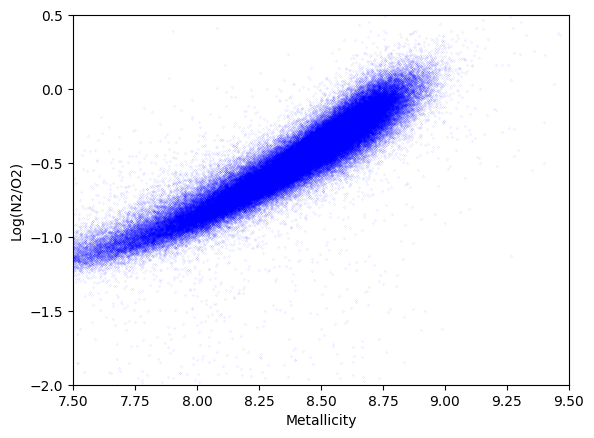

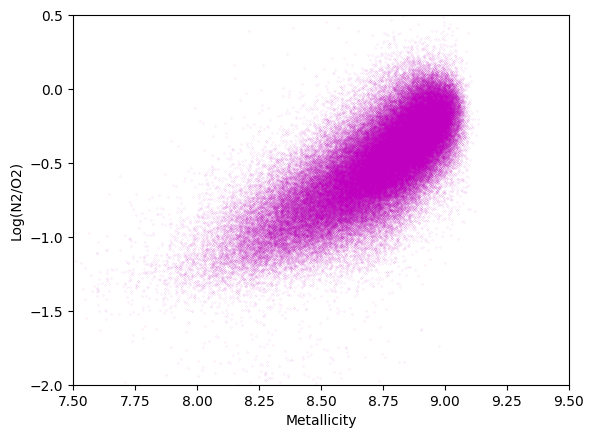

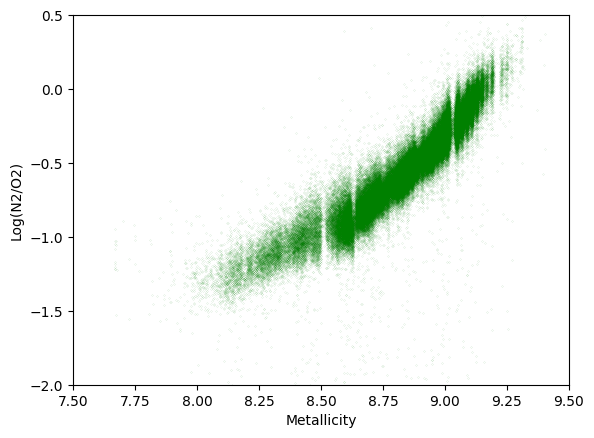

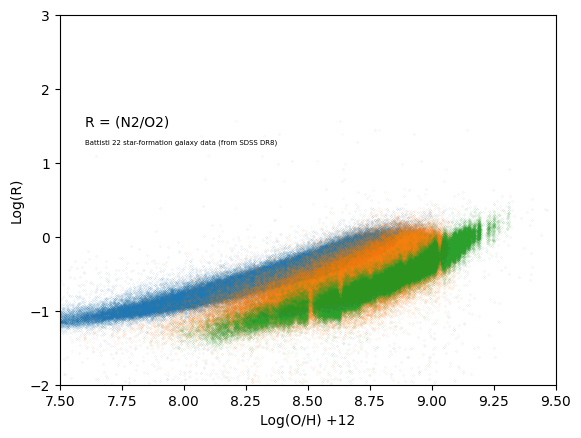

In [261]:
## Metallicity methods

####
## Dopita 16 Metallicity calculation 
####

# log(O/H) +12 = 8.77 + y + 0.45(y+0.3)^5
# y = log(N2)/S2 + 0.264log(N2)/Ha

## SDSS
# corrected
y = (np.log10(NII84_Batt_int/ SII_Batt_int)) + (0.264*np.log(NII84_Batt_int/Halpha_Batt_int))
logOH_Dop16 =  8.77 + y + 0.45*((y+0.3)**5)
# uncorrected
y1 = (np.log10(NII84_Batt/ SII_Batt)) + (0.264*np.log(NII84_Batt/Halpha_Batt))
logOH_Dop16_unc =  8.77 + y1 + 0.45*((y1+0.3)**5)
# values in a resonable range, but all around 8.7 and 8.8

## MOSDEF
# corrected
y = (np.log10(NII85_MOS_int/ SII_MOS_int)) + (0.264*np.log(NII85_MOS_int/Halpha_MOS_int))
logOH_Dop16_MOS_cor =  8.77 + y + 0.45*((y+0.3)**5)
# uncorrected
y1 = (np.log10(NII85_MOSDEF/ SII_MOSDEF)) + (0.264*np.log(NII85_MOSDEF/Ha_MOSDEF))
logOH_Dop16_MOS_unc =  8.77 + y1 + 0.45*((y1+0.3)**5)

####
## Tremonti 2004 Metallicity Calculation
####

## Mass - Metallicity relationship
# uses mass, independent of dust correction
#log(O/H) +12 = -1.492 + 1.847(logM*) − 0.0802626(logM*)^2
logM_p50 = BattistiSpecProp['logM_p50']
logOH_Tre04 = -1.492 + 1.847*(logM_p50) - 0.0802626*((logM_p50)**2)

## Battisti Tremonti 2004, from SDSS
logOH_p50_Batt = BattistiSpecProp['logOH_p50']

## R23 relationship
# 12+log(O/H) = 9.185-0.313x-0.264x^2 - 0.321x^3
# corrected
R23_cor = np.log10((OII26_Batt_int + OIII_Batt_int)/Hbeta_Batt_int)
tre_r23_cor = 9.185-(0.313*R23_cor)-(0.264*(R23_cor**2)) - (0.321*(R23_cor**3))
# Uncorrected
R23_unc = np.log10((OII26_Batt + OIII_Batt)/Hbeta_Batt)
tre_r23_unc = 9.185-(0.313*R23_unc)-(0.264*(R23_unc**2)) - (0.321*(R23_unc**3))

# Questions:
# Paper refers to 6574 line for NII ? Not in SDSS data either. Using NII 84 above. Looks like 
# dopita 16 paper uses 6584
# Tremonti 2004 calls for OII 27 line, we have 26 and 29, so I added them. Should I add the 
# OIII lines? 

## Sanity check: N2/O2

x = logOH_Dop16
x2 = logOH_Tre04
x3 = logOH_p50_Batt
y = np.log10(NII84_Batt_int / OII_Batt_int) 
#Plot
plt.scatter(x,y,s=0.01, c='b', marker='.')
plt.xlim([7.5,9.5])
plt.ylim([-2,0.5])
plt.xlabel("Metallicity")
plt.ylabel("Log(N2/O2)")
#plt.text(0,1,"Corrected for dust")
plt.show()
#Plot
plt.scatter(x2,y,s=0.01, c='m', marker='.')
plt.xlim([7.5,9.5])
plt.ylim([-2,0.5])
plt.xlabel("Metallicity")
plt.ylabel("Log(N2/O2)")
#plt.text(0,1,"Corrected for dust")
plt.show()
#Plot
plt.scatter(x3,y,s=0.01, c='g', marker='.')
plt.xlim([7.5,9.5])
plt.ylim([-2,0.5])
plt.xlabel("Metallicity")
plt.ylabel("Log(N2/O2)")
#plt.text(0,1,"Corrected for dust")
plt.show()

plt.plot(x, y, '.',markersize=.1)#, t1b, p1b(t1b), '-',markersize=.1)
plt.plot(x2, y, '.',markersize=.1)
plt.plot(x3, y, '.',markersize=.1)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = (N2/O2)")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

Testing Ratios (No SII)

/tmp/ipykernel_4004564/1688048990.py:14: RuntimeWarning: divide by zero encountered in log10
  O3_HaN2_Batt = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/1688048990.py:14: RuntimeWarning: invalid value encountered in log10
  O3_HaN2_Batt = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/1688048990.py:15: RuntimeWarning: invalid value encountered in log10
  HaN2_O3_Batt = np.log10( (NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
/tmp/ipykernel_4004564/1688048990.py:16: RuntimeWarning: divide by zero encountered in log10
  Hb_HaN2_Batt = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/1688048990.py:16: RuntimeWarning: invalid value encountered in log10
  Hb_HaN2_Batt = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/1688048990.py:17: RuntimeWarning: invalid value encountered in log10
  OIIIHaN2_Hb_Batt = np.log10((OIII_Batt_int+NII84_Batt

[-9.29845947e-03 -7.80915054e-01  1.41995447e+01 -5.87818759e+01]


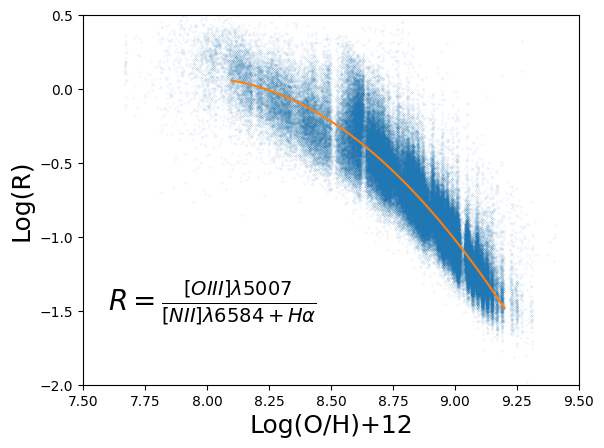

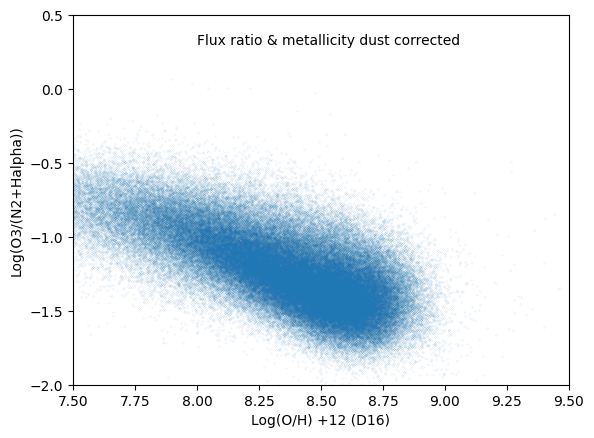

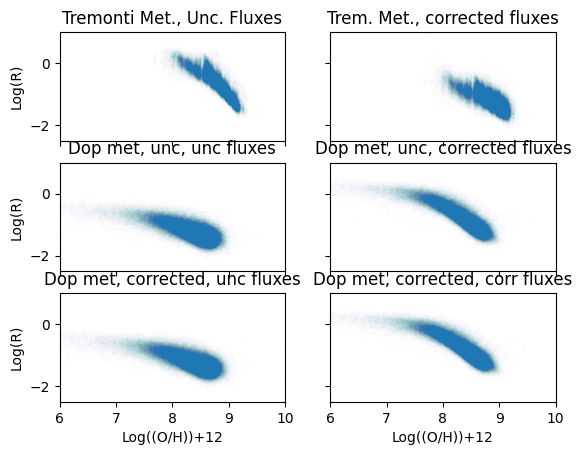

In [262]:
### Low-resolution spectra tests
# No SII

# See this google doc for further context:
# https://docs.google.com/document/d/1Oo44kBQVfmuIUjhzNCpzn1Fku9fEpX672kxPGejz89Y/edit?usp=sharing

# Battisti data values
logOH_p50 = BattistiSpecProp['logOH_p50']
Halpha_Batt_int = x*Halpha_Batt
Hbeta_Batt_int = (pow(10,0.4*k_Hb*EB_V))*Hbeta_Batt
NII84_Batt_int = (pow(10,0.4*k_NII84*EB_V))*NII84_Batt

# Battisti variables, corrected
O3_HaN2_Batt = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
HaN2_O3_Batt = np.log10( (NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
Hb_HaN2_Batt = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
OIIIHaN2_Hb_Batt = np.log10((OIII_Batt_int+NII84_Batt_int+Halpha_Batt_int)/Hbeta_Batt_int )
OIII_HbHaN2_Batt = np.log10(OIII_Batt_int/(Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) )
HbHaN2_OIII_Batt = np.log10((Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int )
OIIIHb_HaN2_Batt = np.log10((Hbeta_Batt_int+OIII_Batt_int)/(NII84_Batt_int+Halpha_Batt_int) )
HaN2_OIIIHb_Batt = np.log10((NII84_Batt_int+Halpha_Batt_int)/(Hbeta_Batt_int+OIII_Batt_int) )

# Battisti variables, uncorrected
O3_HaN2_Batt_unc = np.log10( OIII_Batt / (NII84_Batt+Halpha_Batt) )

## OIII / Ha+NII vs metallicity

x = logOH_p50 # Battisti metallicity 
x2 = logOH_Dop16 # Dopita metallicity, with corrected fluxes
x3 = logOH_Tre04
y1 = O3_HaN2_Batt # Battisti corrected fluxes
y2 = O3_HaN2_Batt_unc # Battisti uncorrected fluxes 

# Flux error
#OIII_err_Batt = BattistiSpecLine['OIII_5007_err']
#NII84_err_Batt = BattistiSpecLine['NII_6584_err']
#Ha_err_Batt = BattistiSpecLine['Ha_err']
#y_err = np.log10( OIII_err_Batt / (NII84_err_Batt+Ha_err_Batt) )

# Original plot, uncorrected battisti data and trem. met.

fit1 = np.polyfit(x, y2,3)
print(fit1)
p1 = np.poly1d(fit1)
t1 = np.linspace(8.1, 9.2, 5000)
plt.plot(x, y2, '.', t1, p1(t1), '-',markersize=.1)#
#plt.errorbar(x, y1, yerr=y_err)
plt.xlabel("Log(O/H)+12",size=18)
plt.xlim([7.5,9.5])
plt.ylim([-2,0.5])
plt.ylabel("Log(R)",size=18)
plt.text(7.6,-1.5,r'$R = \frac{[OIII]\lambda5007}{[NII]\lambda6584+H\alpha}$',size=20)
#plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

# Corrected battisti fluxes and dopita corrected metallicity

#fit2 = np.polyfit(x2, y1,1)
#print(fit2)
#p2 = np.poly1d(fit2)
#t2 = np.linspace(6.1, 9.2, 5000)
plt.plot(x2, y1,'.',markersize=.1)#, t2, p2(t2), '-',markersize=.1)
#plt.errorbar(x, y1, yerr=y_err)
plt.xlabel("Log(O/H) +12 (D16)")
plt.xlim([7.5,9.5])
plt.ylim([-2,0.5])
plt.ylabel("Log(O3/(N2+Halpha))")
plt.text(8,0.3,"Flux ratio & metallicity dust corrected")
#plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()


# Make subplots:
x = logOH_p50 # Battisti metallicity 
x2 = logOH_Dop16 # Dopita metallicity, with corrected fluxes
x3 = logOH_Dop16_unc # Dopita metallicity, with uncorrected fluxes
y1 = O3_HaN2_Batt # Battisti corrected fluxes
y2 = O3_HaN2_Batt_unc # Battisti uncorrected fluxes 

fig, axs = plt.subplots(3, 2)
# Original, Battisti metallicity and uncorrected fluxes
axs[0, 0].plot(x, y2, '.',markersize=.01)
axs[0, 0].set_title('Tremonti Met., Unc. Fluxes')
axs[0, 0].set_xlim([7.5,9.5])
axs[0, 0].set_ylim([-2,0.5])
# Battisti metallicity and corrected fluxes
axs[0, 1].plot(x, y1, '.',markersize=.01)
axs[0, 1].set_title('Trem. Met., corrected fluxes')
axs[0, 1].set_xlim([7.5,9.5])
axs[0, 1].set_ylim([-12,-2.5])
# Dopita metallicity, uncorrected, and uncorrected fluxes
axs[1,0].plot(x3, y1, '.',markersize=.01)
axs[1,0].set_title('Dop met, unc, unc fluxes')
axs[1,0].set_xlim([7.5,9.5])
axs[1,0].set_ylim([-12,-2.5])
# Dopita metallicity, uncorrected, and corrected fluxes
axs[1,1].plot(x3, y2, '.',markersize=.01)
axs[1,1].set_title('Dop met, unc, corrected fluxes')
axs[1,1].set_xlim([7.5,9.5])
axs[1,1].set_ylim([-12,-2.5])
# Dopita metallicity, corrected, and uncorrected fluxes
axs[2,0].plot(x2, y1, '.',markersize=.01)
axs[2,0].set_title('Dop met, corrected, unc fluxes')
axs[2,0].set_xlim([7.5,9.5])
axs[2,0].set_ylim([-12,-2.5])
# Dopita metallicity, corrected, and corrected fluxes
axs[2,1].plot(x2, y2, '.',markersize=.01)
axs[2,1].set_title('Dop met, corrected, corr fluxes')
axs[2,1].set_xlim([7.5,9.5])
axs[2,1].set_ylim([-12,-2.5])

#axs[1, 0].plot(x, -y, 'tab:green')
#axs[1, 0].set_title('Axis [1, 0]')
#axs[1, 1].plot(x, -y, 'tab:red')
#axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel="Log((O/H))+12", ylabel="Log(R)")
    ax.set_xlim([6, 10])
    ax.set_ylim([-2.5, 1])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Comparing Known Diagnostics

/tmp/ipykernel_4004564/4248932863.py:10: RuntimeWarning: divide by zero encountered in divide
  y1 = np.log10(NII84_Batt_int / OII_Batt_int)


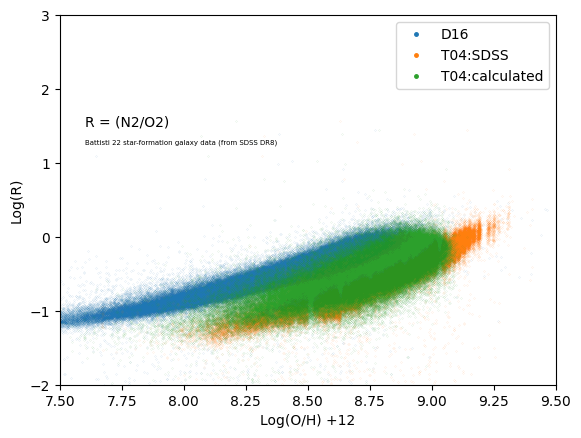

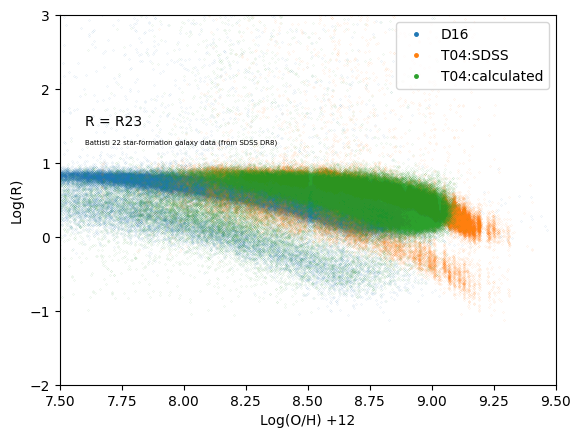

/tmp/ipykernel_4004564/4248932863.py:42: RuntimeWarning: divide by zero encountered in divide
  y3 = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int))
/tmp/ipykernel_4004564/4248932863.py:42: RuntimeWarning: invalid value encountered in log10
  y3 = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int))


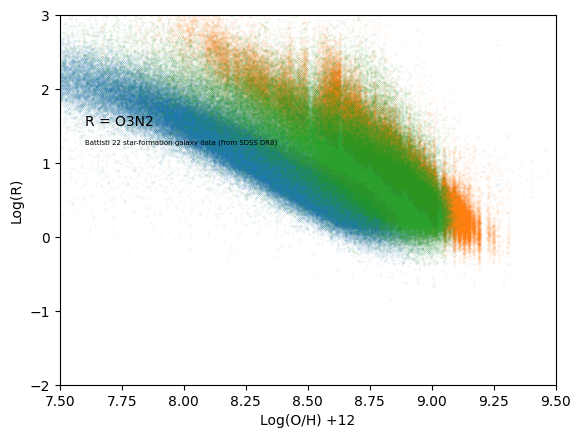

/tmp/ipykernel_4004564/4248932863.py:65: RuntimeWarning: divide by zero encountered in log10
  y4 = np.log10(NII84_Batt_int / Halpha_Batt_int)
/tmp/ipykernel_4004564/4248932863.py:65: RuntimeWarning: invalid value encountered in log10
  y4 = np.log10(NII84_Batt_int / Halpha_Batt_int)


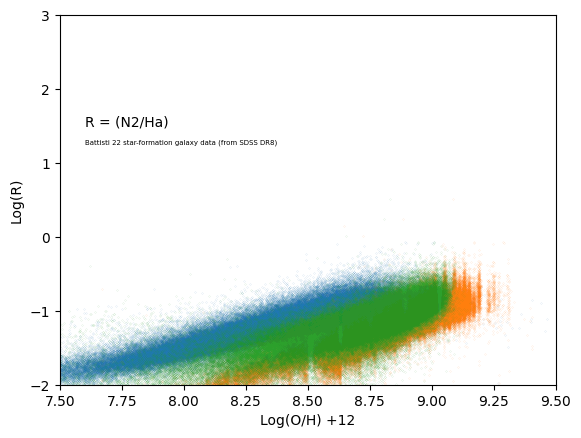

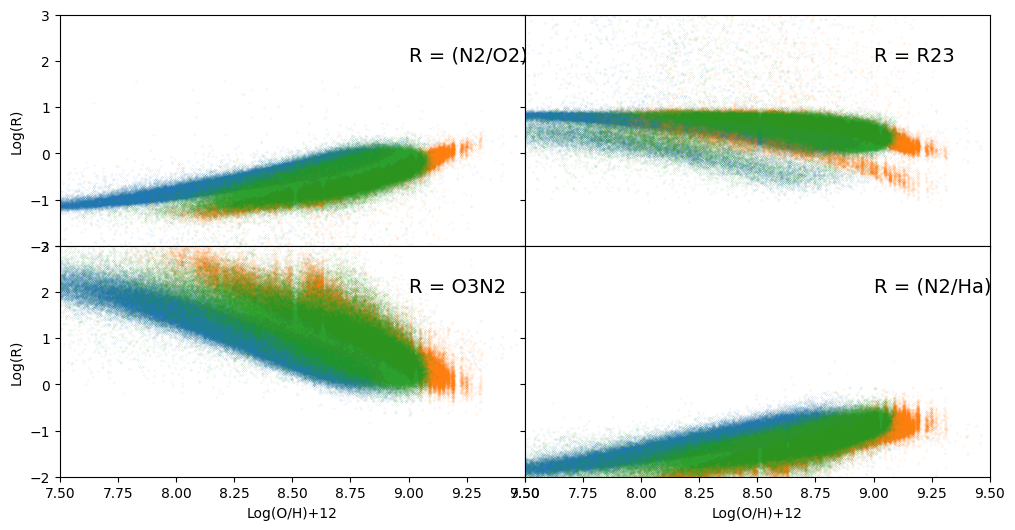

In [263]:
## Comparison to known trends

# Metallicities 
x = logOH_Dop16
# SDSS metallicity
x2 = logOH_p50
x3 = logOH_Tre04

# N2/O2
y1 = np.log10(NII84_Batt_int / OII_Batt_int) 

p1 = plt.plot(x, y1, '.',markersize=.1)#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(x2, y1, '.',markersize=.1)
p3 = plt.plot(x3, y1, '.',markersize=.1)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = (N2/O2)")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
plt.legend((p1[0], p2[0], p3[0]), ('D16', 'T04:SDSS', 'T04:calculated'),fontsize=10,markerscale=50,loc='upper right')
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## R23 R =[OII]λ3727,9+[OIII]λ4959,5007/Hβ) 
y2 = np.log10((OII_Batt_int + OIII_Batt_int)/Hbeta_Batt_int)

p1 = plt.plot(x, y2, '.',markersize=.1)#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(x2, y2, '.',markersize=.1)
p3 = plt.plot(x3, y2, '.',markersize=.1)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = R23")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
plt.legend((p1[0], p2[0], p3[0]), ('D16', 'T04:SDSS', 'T04:calculated'),fontsize=10,markerscale=50,loc='upper right')
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## O3N2 (R = [OIII]λ5007/Hβ/[NII]λ6584/Hα
y3 = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int)) 
o3n2x = np.arange(-2, 3, 0.05) # log(O3N2)
o3n2y = [-3.98,-3.73,-3.48,-3.23,-2.98,-2.73,-2.48,-2.23,-1.98] # log(U) values

plt.plot(x, y3, '.',markersize=.1)#, t1b, p1b(t1b), '-',markersize=.1)
plt.plot(x2, y3, '.',markersize=.1)
plt.plot(x3, y3, '.',markersize=.1)
plt.subplot(111)
for i in o3n2y:
    z = 10.312 -(1.6575*o3n2x) + 2.2525*i - (1.3594*i*o3n2x) +0.4764*(o3n2x**2) + 1.173*(i**2) - (0.2968*o3n2x*(i**2)) +0.1974*i*(o3n2x**2) 
    - (0.0544*(o3n2x**3)) +0.1891*(i**3) # metallicity, x axis   
    #print(z)
    plt.plot(z,o3n2x,'-')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = O3N2")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## N2/ Ha
y4 = np.log10(NII84_Batt_int / Halpha_Batt_int) 

plt.plot(x, y4, '.',markersize=.1)#, t1b, p1b(t1b), '-',markersize=.1)
plt.plot(x2, y4, '.',markersize=.1)
plt.plot(x3, y4, '.',markersize=.1)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = (N2/Ha)")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2,2,wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
# N2/O2
axs[0, 0].plot(x, y1, '.',markersize=.1)
axs[0, 0].plot(x2, y1, '.',markersize=.1)
axs[0, 0].plot(x3, y1, '.',markersize=.1)
axs[0, 0].text(9,2,"R = (N2/O2)",size=14)
# R23
axs[0, 1].plot(x, y2, '.',markersize=.1)
axs[0, 1].plot(x2, y2, '.',markersize=.1)
axs[0, 1].plot(x3, y2, '.',markersize=.1)
axs[0, 1].text(9,2,"R = R23",size=14)
# O3N2
axs[1,0].plot(x, y3, '.',markersize=.1)
axs[1,0].plot(x2, y3, '.',markersize=.1)
axs[1,0].plot(x3, y3, '.',markersize=.1)
## attempting to pull in the model
o3n2x = np.arange(-2, 3, 0.05) # log(O3N2)
o3n2y = [-3.98,-3.73,-3.48,-3.23,-2.98,-2.73,-2.48,-2.23,-1.98] # log(U) values
#plt.subplot(111)
for i in o3n2y:
    z = 10.312 -(1.6575*o3n2x) + 2.2525*i - (1.3594*i*o3n2x) +0.4764*(o3n2x**2) + 1.173*(i**2) - (0.2968*o3n2x*(i**2)) +0.1974*i*(o3n2x**2) 
    - (0.0544*(o3n2x**3)) +0.1891*(i**3) # metallicity, x axis   
    #print(z)
    axs[1,0].plot(z,o3n2x,'-')
axs[1,0].text(9,2,"R = O3N2",size=14)
# N2/Ha
axs[1,1].plot(x, y4, '.',markersize=.1)
axs[1,1].plot(x2, y4, '.',markersize=.1)
axs[1,1].plot(x3, y4, '.',markersize=.1)
axs[1,1].text(9,2,"R = (N2/Ha)",size=14)

for ax in axs.flat:
    ax.set(xlabel="Log(O/H)+12", ylabel="Log(R)")
    ax.set_xlim([7.5, 9.5])
    ax.set_ylim([-2, 3])
    #ax.legend("D16","SDSS Tre 04","Calc Tre 04")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()



    


Dust Correcting New Trends

/tmp/ipykernel_4004564/2835379279.py:12: RuntimeWarning: divide by zero encountered in log10
  O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/2835379279.py:12: RuntimeWarning: invalid value encountered in log10
  O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/2835379279.py:13: RuntimeWarning: invalid value encountered in log10
  HaN2_O3_Batt_int = np.log10( (NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
/tmp/ipykernel_4004564/2835379279.py:14: RuntimeWarning: divide by zero encountered in log10
  Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/2835379279.py:14: RuntimeWarning: invalid value encountered in log10
  Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/2835379279.py:15: RuntimeWarning: invalid value encountered in log10
  HaN2_Hb_Batt_int = np.log10( (NII

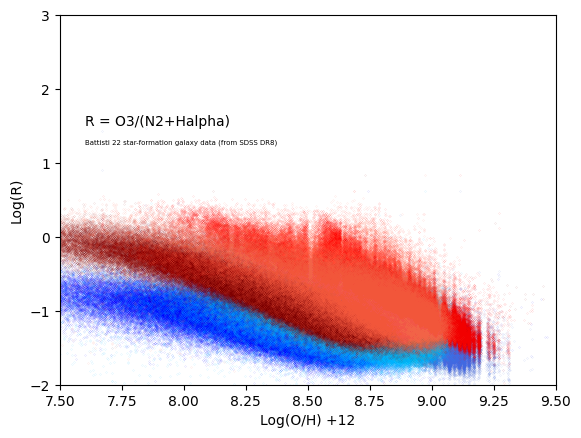

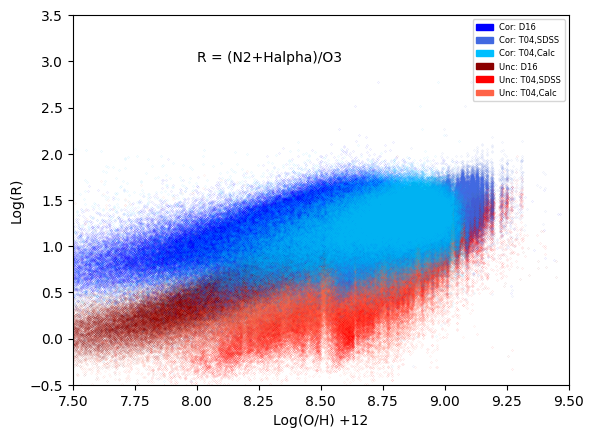

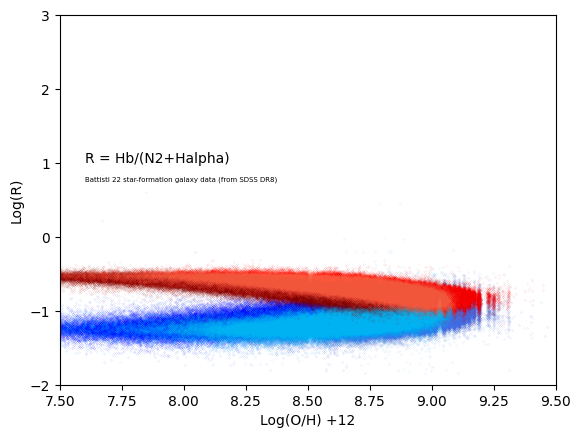

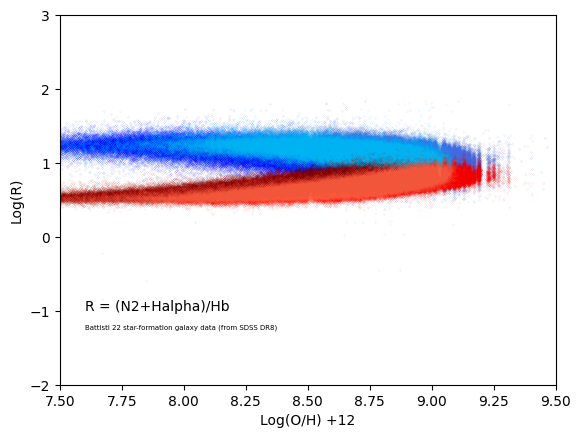

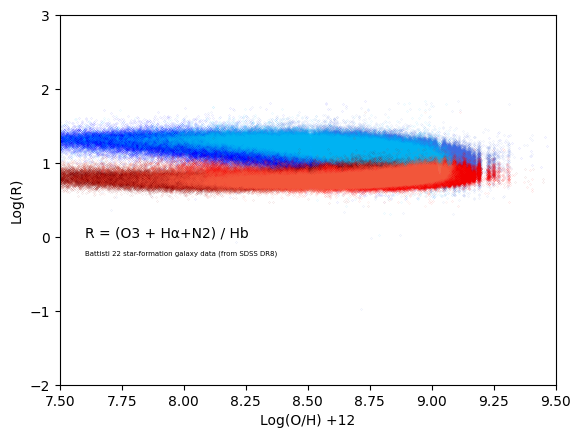

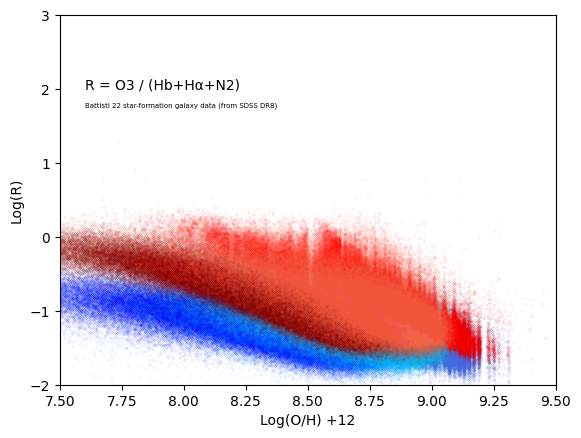

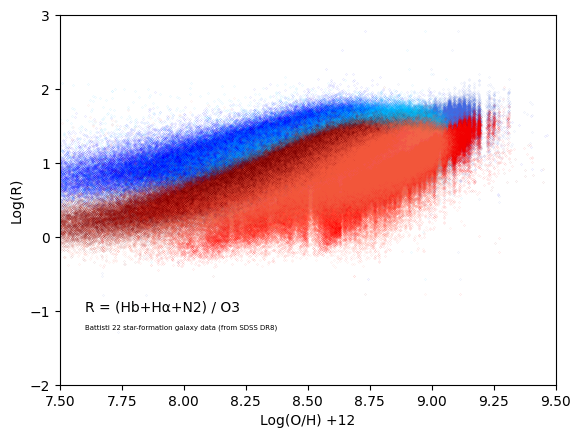

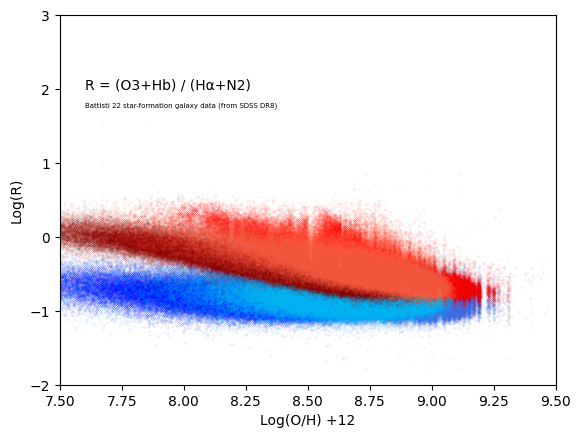

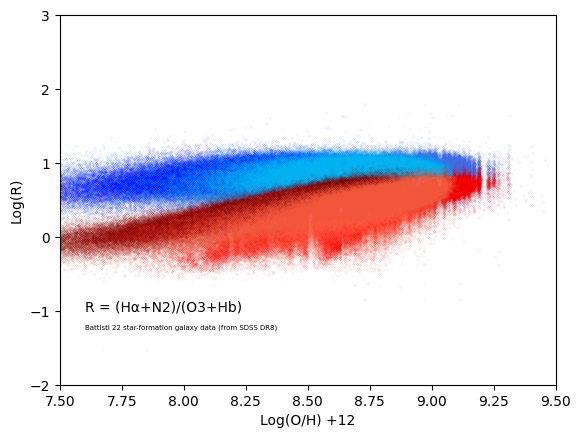

In [264]:
## New relations, low resolution
## Corrected vs. Uncorrected data

# Metallicities 
dop_int = logOH_Dop16
dop_unc = logOH_Dop16_unc
# SDSS metallicity
tre_sdss = logOH_p50
tre_calc = logOH_Tre04

# Battisti variables, corrected
O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
HaN2_O3_Batt_int = np.log10( (NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
HaN2_Hb_Batt_int = np.log10( (NII84_Batt_int+Halpha_Batt_int)/Hbeta_Batt_int )
OIIIHaN2_Hb_Batt_int = np.log10((OIII_Batt_int+NII84_Batt_int+Halpha_Batt_int)/Hbeta_Batt_int )
OIII_HbHaN2_Batt_int = np.log10(OIII_Batt_int/(Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) )
HbHaN2_OIII_Batt_int = np.log10((Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int )
OIIIHb_HaN2_Batt_int = np.log10((Hbeta_Batt_int+OIII_Batt_int)/(NII84_Batt_int+Halpha_Batt_int) )
HaN2_OIIIHb_Batt_int = np.log10((NII84_Batt_int+Halpha_Batt_int)/(Hbeta_Batt_int+OIII_Batt_int) )

# Battisti variables, uncorrected
O3_HaN2_Batt = np.log10( OIII_Batt / (NII84_Batt+Halpha_Batt) )
HaN2_O3_Batt = np.log10( (NII84_Batt+Halpha_Batt) / OIII_Batt)
Hb_HaN2_Batt = np.log10( Hbeta_Batt / (NII84_Batt+Halpha_Batt) )
HaN2_Hb_Batt = np.log10( (NII84_Batt+Halpha_Batt)/Hbeta_Batt )
OIIIHaN2_Hb_Batt = np.log10((OIII_Batt+NII84_Batt+Halpha_Batt)/Hbeta_Batt )
OIII_HbHaN2_Batt = np.log10(OIII_Batt/(Hbeta_Batt+NII84_Batt+Halpha_Batt) )
HbHaN2_OIII_Batt = np.log10((Hbeta_Batt+NII84_Batt+Halpha_Batt) / OIII_Batt )
OIIIHb_HaN2_Batt = np.log10((Hbeta_Batt+OIII_Batt)/(NII84_Batt+Halpha_Batt) )
HaN2_OIIIHb_Batt = np.log10((NII84_Batt+Halpha_Batt)/(Hbeta_Batt+OIII_Batt) )

## OIII / NII+Ha

#fit1b = np.polyfit(x, y1b, 3)
#print(fit1b)
#p1b = np.poly1d(fit1b)
#t1b = np.linspace(8.1, 9.2, 5000)
# corrected
p1 = plt.plot(dop_int, O3_HaN2_Batt_int, '.',markersize=.1,color='blue',label='Cor: D16')#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(tre_sdss, O3_HaN2_Batt_int, '.',markersize=.1,color='royalblue',label='Cor: T04,SDSS')
p3 = plt.plot(tre_calc, O3_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue',label='Cor: T04,Calc')
# uncorrected
p4 = plt.plot(dop_unc, O3_HaN2_Batt, '.',markersize=.1,color='darkred')
p5 = plt.plot(tre_sdss, O3_HaN2_Batt, '.',markersize=.1,color='red')
p6 = plt.plot(tre_calc, O3_HaN2_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = O3/(N2+Halpha)")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
plt.show()

# NII+Ha / OIII
# uncorrected
p4 = plt.plot(dop_unc, HaN2_O3_Batt, '.',markersize=.1,color='darkred')
p5 = plt.plot(tre_sdss, HaN2_O3_Batt, '.',markersize=.1,color='red')
p6 = plt.plot(tre_calc, HaN2_O3_Batt, '.',markersize=.1,color='tomato')
# corrected
p1 = plt.plot(dop_int, HaN2_O3_Batt_int, '.',markersize=.1,color='blue',label='Cor: D16')#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(tre_sdss, HaN2_O3_Batt_int, '.',markersize=.1,color='royalblue',label='Cor: T04,SDSS')
p3 = plt.plot(tre_calc, HaN2_O3_Batt_int, '.',markersize=.1,color='deepskyblue',label='Cor: T04,Calc')
plt.legend()
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-0.5,3.5])
plt.ylabel("Log(R)")
plt.text(8,3,"R = (N2+Halpha)/O3")
#plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)

p1l = mpatches.Patch(color='blue',label='Cor: D16')
p2l = mpatches.Patch(color='royalblue',label='Cor: T04,SDSS')
p3l = mpatches.Patch(color='deepskyblue',label='Cor: T04,Calc')
p4l = mpatches.Patch(color='darkred',label='Unc: D16')
p5l = mpatches.Patch(color='red',label='Unc: T04,SDSS')
p6l = mpatches.Patch(color='tomato',label='Unc: T04,Calc')

plt.legend(handles=[p1l,p2l,p3l,p4l,p5l,p6l], fontsize=6)
#plt.legend([p1,p2,p3],['D16','Tre SDSS','Tre Calc'])#,fontsize=10,markerscale=5,loc='upper right')
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()



## Hb / Ha+NII vs metallicity

#fit2 = np.polyfit(x, y2, 3)
#print(fit2)
#p2 = np.poly1d(fit2)
#t2 = np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, Hb_HaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, Hb_HaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, Hb_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, Hb_HaN2_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, Hb_HaN2_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, Hb_HaN2_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1,"R = Hb/(N2+Halpha)")
plt.text(7.6,0.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## Ha+NII / Hb vs metallicity

#fit2 = np.polyfit(x, y2, 3)
#print(fit2)
#p2 = np.poly1d(fit2)
#t2 = np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HaN2_Hb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HaN2_Hb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HaN2_Hb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, HaN2_Hb_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, HaN2_Hb_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, HaN2_Hb_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (N2+Halpha)/Hb")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()


## OIII + H⍺+NII / H𝛽  vs. metallicity

#fit3 = np.polyfit(x, y3, 3)
#print(fit3)
#p3 = np.poly1d(fit3)
#t3= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,0,"R = (O3 + H⍺+N2) / Hb")
plt.text(7.6,-0.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## OIII / H𝛽 + H⍺+NII

#fit4 = np.polyfit(x, y4, 3)
#print(fit4)
#p4 = np.poly1d(fit4)
#t4= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, OIII_HbHaN2_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, OIII_HbHaN2_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, OIII_HbHaN2_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,2,"R = O3 / (Hb+H⍺+N2)")
plt.text(7.6,1.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## H𝛽 + H⍺+NII / OIII 

#fit4b = np.polyfit(x, y4b, 3)
#print(fit4b)
#p4b = np.poly1d(fit4b)
#t4b= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, HbHaN2_OIII_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, HbHaN2_OIII_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, HbHaN2_OIII_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (Hb+H⍺+N2) / O3")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## OIII+H𝛽 / H⍺+NII

#fit5 = np.polyfit(x, y5, 3)
#print(fit5)
#p5 = np.poly1d(fit5)
#t5= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, OIIIHb_HaN2_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, OIIIHb_HaN2_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, OIIIHb_HaN2_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,2,"R = (O3+Hb) / (H⍺+N2)")
plt.text(7.6,1.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## H⍺+NII / OIII+H𝛽 

#fit5b = np.polyfit(x, y5b, 3)
#print(fit5b)
#p5b = np.poly1d(fit5b)
#t5b= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, HaN2_OIIIHb_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, HaN2_OIIIHb_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, HaN2_OIIIHb_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (H⍺+N2)/(O3+Hb)")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()


MAPPINGS Model

('LogQ1', 'age2', 'TotO123', 'gasO124', 'TotFe5', 'gasFe6', 'LogPk7', 'NIIHa8', 'NIIHa9', 'SIIHa10', 'NIIOII11', 'NIIOII12', 'NIISII13', 'NIISII14', 'OIIHb15', 'OIIIHb16', 'OIIIHb17', 'OIIIOII18', 'OIIIOII19', 'OIIISII20', 'OIIISII21', '4363OIII22', '4363OIII23', 'OIOII24', 'OIISII25', 'R2326', 'S2327', '6716673128', '3729372629', 'Hbeta_abs30', 'HBeta31', 'Rout32', 'Rmax33', 'Remp34', 'NIIHb35', 'HaHb36')


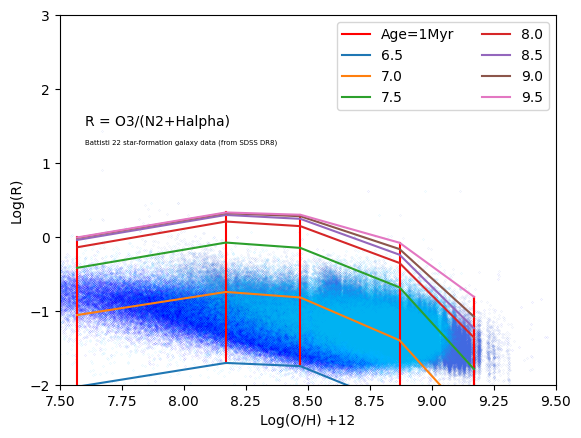

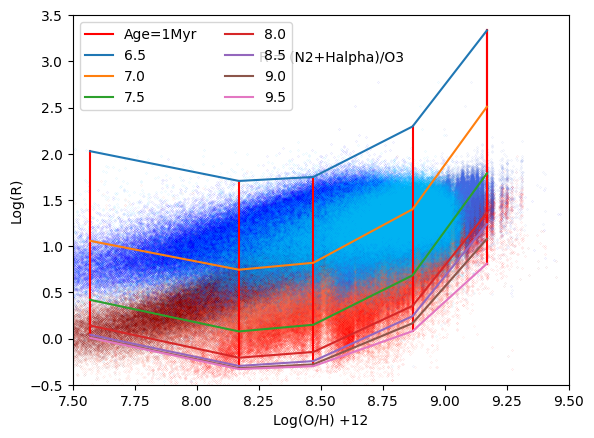

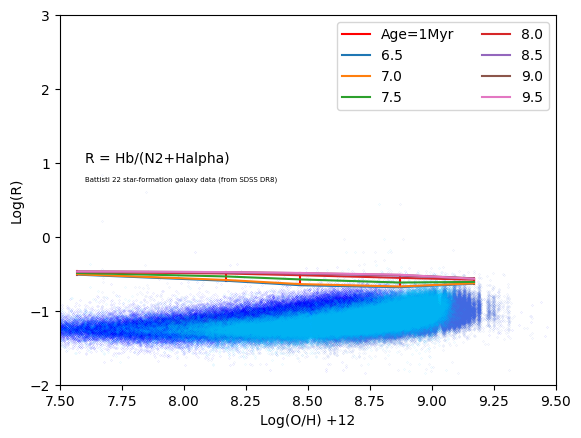

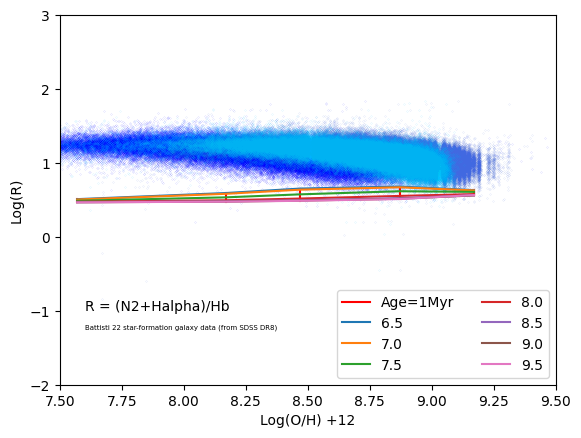

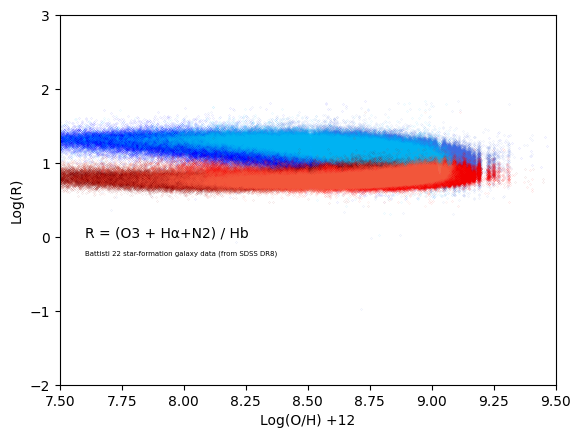

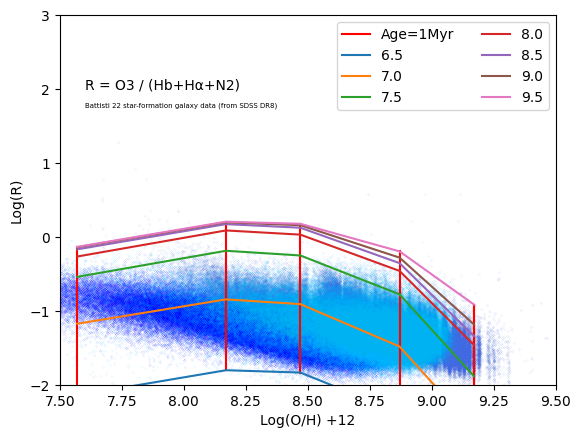

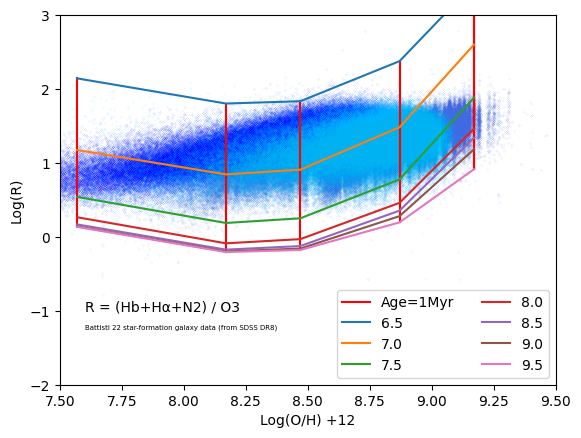

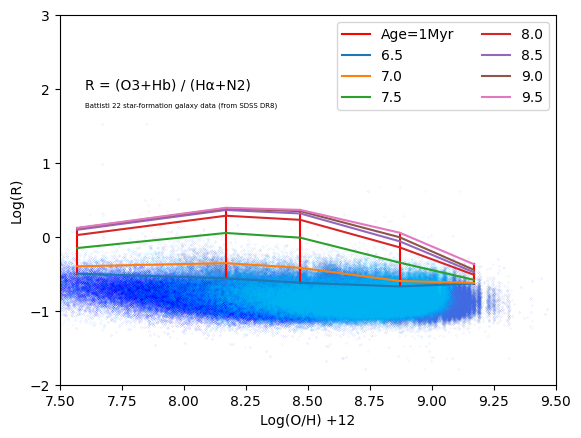

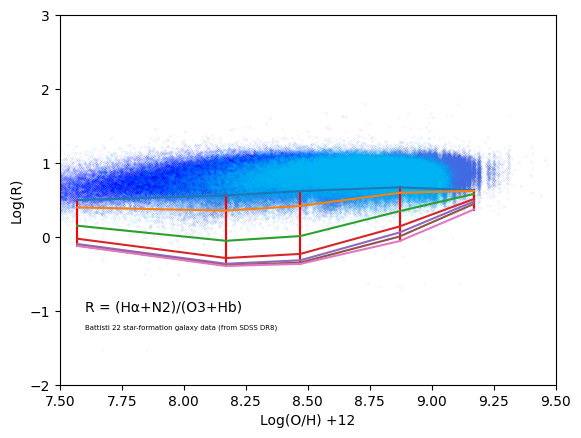

In [265]:
## Pull in MAPPINGS model parameters
print(BPASS.dtype.names)

# Each line in the ratio is logged. So need to consider thant when creating the ratio values. 
# Lines are over Ha, so need to cancel out Ha 

BPASS = np.loadtxt('grid_bpass_P6.csv', skiprows=1, delimiter=',')
logQ_model = BPASS[:,0]
stellarage_model =BPASS[:,1]
metal_model = BPASS[:,2]
pressure_model = BPASS[:,6]

# Logged values!
N2_Ha_model = BPASS[:,7]  # Not the NII doublet
N2_O2p_model = BPASS[:,10] # OII doublet
O2p_Hb_model = BPASS[:,14] # OII doublet 
O3_Hb_model = BPASS[:,15] 
O32_model = BPASS[:,17]  # OIII / OII doublet
R23_model = BPASS[:,25]  # OIII doub + OII doub / Hb
Ha_Hb_model = BPASS[:,35]

# Radius of spherical clouds
rad = BPASS[:,31]
rmax = BPASS[:,32]
remp = BPASS[:,33]

LHb_model = BPASS[:,30]  # Hbeta luminosity
Hb_model = LHb_model / (4*np.pi*rmax**2) # Hbeta flux

# converting logged line ratios 
N2_Hb_model = N2_Ha_model + Ha_Hb_model  # log(NII/Hb)
Ha_model = Ha_Hb_model + Hb_model # log(Ha)
N2_model = N2_Hb_model + Hb_model # log(N2)
N2Ha_model = np.log10(10**N2_model + 10**Ha_model) # log(N2 + Ha)
O3_model = O3_Hb_model + Hb_model # log(OIII)
O3Hb_model = np.log10(10**O3_model + 10**Hb_model) # log(o3 + Hb)
HaN2Hb_model = np.log10(10**N2_model + 10**Ha_model + 10**Hb_model) # log(N2 + Ha +Hb)

## Model ratios 
## (Ha + NII) / OIII
HaN2_O3_model = np.log10(10**N2_Hb_model + 10**Ha_Hb_model) - O3_Hb_model
## OIII / (Ha + NII)
O3_HaN2_model = O3_Hb_model - np.log10(10**N2_Hb_model + 10**Ha_Hb_model)
## Hb / Ha+N2
Hb_HaN2_model = Hb_model - N2Ha_model
## Ha+N2 / Hb
HaN2_Hb_model =  N2Ha_model - Hb_model
## O3+Hb / Ha+NII
O3Hb_HaN2_model = O3Hb_model - N2Ha_model
## Ha+NII / O3+Hb
HaN2_O3Hb_model =  N2Ha_model - O3Hb_model
## O3 / Ha+N2+Hb
O3_HaN2Hb_model = O3_model - HaN2Hb_model
## Ha+N2+Hb / O3
HaN2Hb_O3_model = HaN2Hb_model - O3_model 

Qlist = np.unique(logQ_model)
Qlist_names = [6.5,7.0,7.5,8.0,8.5,9.0,9.5]
Zlist = np.unique(metal_model)


## OIII / NII+Ha

#fit1b = np.polyfit(x, y1b, 3)
#print(fit1b)
#p1b = np.poly1d(fit1b)
#t1b = np.linspace(8.1, 9.2, 5000)
# corrected
p1 = plt.plot(dop_int, O3_HaN2_Batt_int, '.',markersize=.1,color='blue')#,label='Cor: D16')#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(tre_sdss, O3_HaN2_Batt_int, '.',markersize=.1,color='royalblue')#,label='Cor: T04,SDSS')
p3 = plt.plot(tre_calc, O3_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue')#,label='Cor: T04,Calc')
# uncorrected
#p4 = plt.plot(dop_unc, O3_HaN2_Batt, '.',markersize=.1,color='darkred')
#p5 = plt.plot(tre_sdss, O3_HaN2_Batt, '.',markersize=.1,color='red')
#p6 = plt.plot(tre_calc, O3_HaN2_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3_HaN2_model[w], '-', c='r')
plt.plot(metal_model[w], O3_HaN2_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3_HaN2_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1.5,"R = O3/(N2+Halpha)")
plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
plt.show()

# NII+Ha / OIII
# uncorrected
p4 = plt.plot(dop_unc, HaN2_O3_Batt, '.',markersize=.1,color='darkred')
p5 = plt.plot(tre_sdss, HaN2_O3_Batt, '.',markersize=.1,color='red')
p6 = plt.plot(tre_calc, HaN2_O3_Batt, '.',markersize=.1,color='tomato')
# corrected
p1 = plt.plot(dop_int, HaN2_O3_Batt_int, '.',markersize=.1,color='blue')#,label='Cor: D16')#, t1b, p1b(t1b), '-',markersize=.1)
p2 = plt.plot(tre_sdss, HaN2_O3_Batt_int, '.',markersize=.1,color='royalblue')#,label='Cor: T04,SDSS')
p3 = plt.plot(tre_calc, HaN2_O3_Batt_int, '.',markersize=.1,color='deepskyblue')#,label='Cor: T04,Calc')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='r')
plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-0.5,3.5])
plt.ylabel("Log(R)")
plt.text(8.25,3,"R = (N2+Halpha)/O3")
#plt.text(7.6,1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)

#p1l = mpatches.Patch(color='blue',label='Cor: D16')
#p2l = mpatches.Patch(color='royalblue',label='Cor: T04,SDSS')
#p3l = mpatches.Patch(color='deepskyblue',label='Cor: T04,Calc')
#p4l = mpatches.Patch(color='darkred',label='Unc: D16')
#p5l = mpatches.Patch(color='red',label='Unc: T04,SDSS')
#p6l = mpatches.Patch(color='tomato',label='Unc: T04,Calc')

#plt.legend(handles=[p1l,p2l,p3l], fontsize=6)
#plt.legend([p1,p2,p3],['D16','Tre SDSS','Tre Calc'])#,fontsize=10,markerscale=5,loc='upper right')
#plt.savefig("HaN2_O3_mappings.7.22.pdf",format="pdf")
plt.show()



## Hb / Ha+NII vs metallicity


#fit2 = np.polyfit(x, y2, 3)
#print(fit2)
#p2 = np.poly1d(fit2)
#t2 = np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, Hb_HaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, Hb_HaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, Hb_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, Hb_HaN2_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, Hb_HaN2_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, Hb_HaN2_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], Hb_HaN2_model[w], '-', c='r')
plt.plot(metal_model[w], Hb_HaN2_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], Hb_HaN2_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,1,"R = Hb/(N2+Halpha)")
plt.text(7.6,0.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## Ha+NII / Hb vs metallicity

#fit2 = np.polyfit(x, y2, 3)
#print(fit2)
#p2 = np.poly1d(fit2)
#t2 = np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HaN2_Hb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HaN2_Hb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HaN2_Hb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, HaN2_Hb_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, HaN2_Hb_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, HaN2_Hb_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_Hb_model[w], '-', c='r')
plt.plot(metal_model[w], HaN2_Hb_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_Hb_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (N2+Halpha)/Hb")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()


## OIII + H⍺+NII / H𝛽  vs. metallicity

#fit3 = np.polyfit(x, y3, 3)
#print(fit3)
#p3 = np.poly1d(fit3)
#t3= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIIIHaN2_Hb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
plt.plot(dop_unc, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='darkred')
plt.plot(tre_sdss, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='red')
plt.plot(tre_calc, OIIIHaN2_Hb_Batt, '.',markersize=.1,color='tomato')
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,0,"R = (O3 + H⍺+N2) / Hb")
plt.text(7.6,-0.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## OIII / H𝛽 + H⍺+NII

#fit4 = np.polyfit(x, y4, 3)
#print(fit4)
#p4 = np.poly1d(fit4)
#t4= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIII_HbHaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, OIII_HbHaN2_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, OIII_HbHaN2_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, OIII_HbHaN2_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3_HaN2Hb_model[w], '-', c='r')
plt.plot(metal_model[w], O3_HaN2Hb_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3_HaN2Hb_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,2,"R = O3 / (Hb+H⍺+N2)")
plt.text(7.6,1.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## H𝛽 + H⍺+NII / OIII 


#fit4b = np.polyfit(x, y4b, 3)
#print(fit4b)
#p4b = np.poly1d(fit4b)
#t4b= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HbHaN2_OIII_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, HbHaN2_OIII_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, HbHaN2_OIII_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, HbHaN2_OIII_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2Hb_O3_model[w], '-', c='r')
plt.plot(metal_model[w], HaN2Hb_O3_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2Hb_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (Hb+H⍺+N2) / O3")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## OIII+H𝛽 / H⍺+NII

#fit5 = np.polyfit(x, y5, 3)
#print(fit5)
#p5 = np.poly1d(fit5)
#t5= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, OIIIHb_HaN2_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, OIIIHb_HaN2_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, OIIIHb_HaN2_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, OIIIHb_HaN2_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3Hb_HaN2_model[w], '-', c='r')
plt.plot(metal_model[w], O3Hb_HaN2_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], O3Hb_HaN2_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,2,"R = (O3+Hb) / (H⍺+N2)")
plt.text(7.6,1.75,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()

## H⍺+NII / OIII+H𝛽 

#fit5b = np.polyfit(x, y5b, 3)
#print(fit5b)
#p5b = np.poly1d(fit5b)
#t5b= np.linspace(8.1, 9.2, 5000)
# corrected
plt.plot(dop_int, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='blue')# t2, p2(t2), '-',markersize=.1)
plt.plot(tre_sdss, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='royalblue')
plt.plot(tre_calc, HaN2_OIIIHb_Batt_int, '.',markersize=.1,color='deepskyblue')
# uncorrected
#plt.plot(dop_unc, HaN2_OIIIHb_Batt, '.',markersize=.1,color='darkred')
#plt.plot(tre_sdss, HaN2_OIIIHb_Batt, '.',markersize=.1,color='red')
#plt.plot(tre_calc, HaN2_OIIIHb_Batt, '.',markersize=.1,color='tomato')
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3Hb_model[w], '-', c='r')
plt.plot(metal_model[w], HaN2_O3Hb_model[w], '-', c='r', label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3Hb_model[w], '-',label=Qlist_names[j])
    #plt.legend(ncols=2)
plt.xlabel("Log(O/H) +12")
plt.xlim([7.5,9.5])
plt.ylim([-2,3])
plt.ylabel("Log(R)")
plt.text(7.6,-1,"R = (H⍺+N2)/(O3+Hb)")
plt.text(7.6,-1.25,"Battisti 22 star-formation galaxy data (from SDSS DR8)",size=5)
#plt.savefig("(OIII_Hbeta)_(NII84+Halpha).pdf",format="pdf")
plt.show()


Percentile Plots to determine scatter

/tmp/ipykernel_4004564/3893270404.py:11: RuntimeWarning: divide by zero encountered in log10
  O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/3893270404.py:11: RuntimeWarning: invalid value encountered in log10
  O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/3893270404.py:12: RuntimeWarning: invalid value encountered in log10
  HaN2_O3_Batt_int = np.log10( (NII_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
/tmp/ipykernel_4004564/3893270404.py:13: RuntimeWarning: divide by zero encountered in log10
  Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/3893270404.py:13: RuntimeWarning: invalid value encountered in log10
  Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
/tmp/ipykernel_4004564/3893270404.py:14: RuntimeWarning: invalid value encountered in log10
  HaN2_Hb_Batt_int = np.log10( (NII84

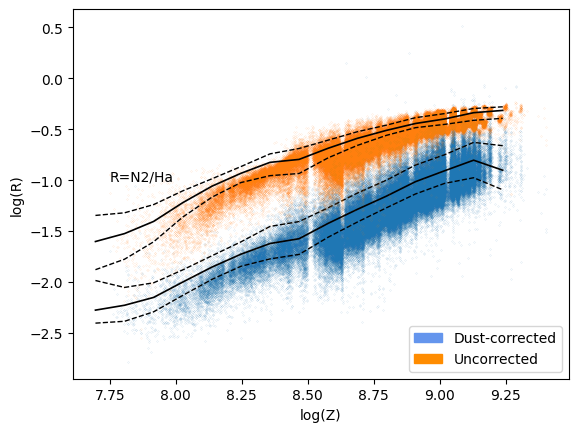

Spearman, uncorrected: 0.9102458188220213
Spearman, corrected: 0.8658143688598379


/tmp/ipykernel_4004564/3893270404.py:99: RuntimeWarning: divide by zero encountered in divide
  O3N2_Batt_int = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int))
/tmp/ipykernel_4004564/3893270404.py:99: RuntimeWarning: invalid value encountered in log10
  O3N2_Batt_int = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int))


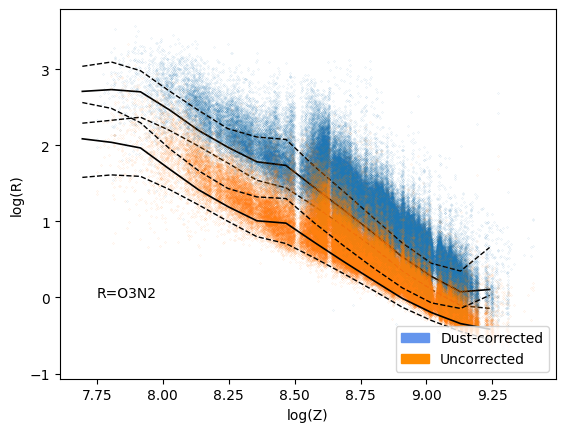

Spearman, uncorrected: -0.9426532961349964
Spearman, corrected: -0.9333374013900017


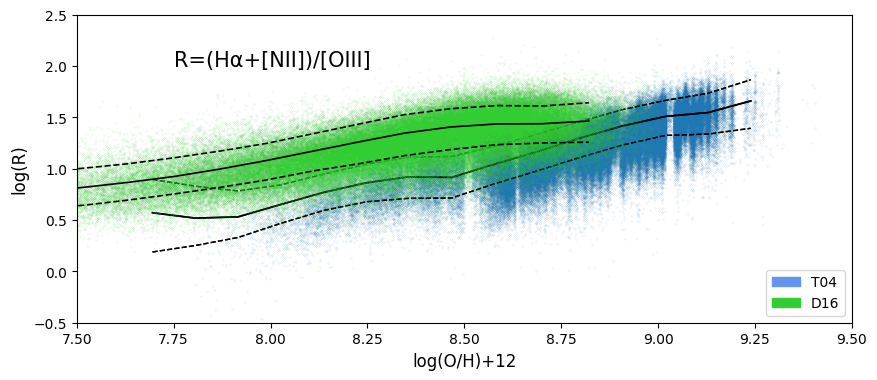

Spearman, uncorrected: 0.9338299754020288
Spearman, corrected: 0.7697360760310381


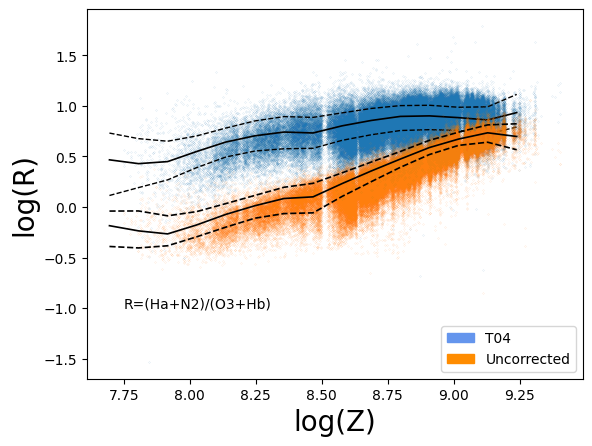

Spearman, uncorrected: 0.9265292857721563
Spearman, corrected: 0.3950520543710325


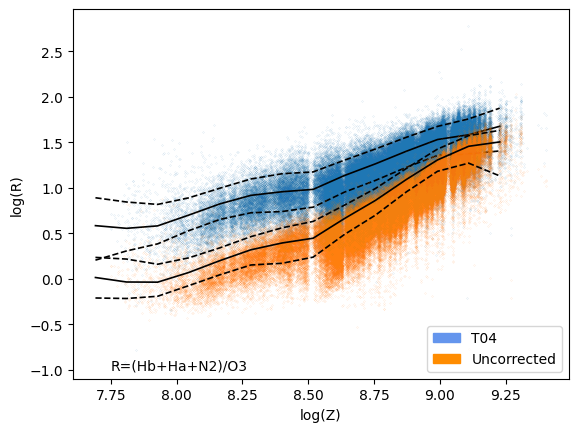

Spearman, uncorrected: 0.9305746765527559
Spearman, corrected: 0.7779901825960307


In [283]:
## Percentile plots to determine scatter

# Metallicities 
dop_int = logOH_Dop16
dop_unc = logOH_Dop16_unc
# SDSS metallicity
tre_sdss = logOH_p50
tre_calc = logOH_Tre04

# Battisti variables, corrected
O3_HaN2_Batt_int = np.log10( OIII_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
HaN2_O3_Batt_int = np.log10( (NII_Batt_int+Halpha_Batt_int) / OIII_Batt_int)
Hb_HaN2_Batt_int = np.log10( Hbeta_Batt_int / (NII84_Batt_int+Halpha_Batt_int) )
HaN2_Hb_Batt_int = np.log10( (NII84_Batt_int+Halpha_Batt_int)/Hbeta_Batt_int )
OIIIHaN2_Hb_Batt_int = np.log10((OIII_Batt_int+NII84_Batt_int+Halpha_Batt_int)/Hbeta_Batt_int )
OIII_HbHaN2_Batt_int = np.log10(OIII_Batt_int/(Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) )
HbHaN2_OIII_Batt_int = np.log10((Hbeta_Batt_int+NII84_Batt_int+Halpha_Batt_int) / OIII_Batt_int )
OIIIHb_HaN2_Batt_int = np.log10((Hbeta_Batt_int+OIII_Batt_int)/(NII84_Batt_int+Halpha_Batt_int) )
HaN2_OIIIHb_Batt_int = np.log10((NII84_Batt_int+Halpha_Batt_int)/(Hbeta_Batt_int+OIII_Batt_int) )

# Battisti variables, uncorrected
O3_HaN2_Batt = np.log10( OIII_Batt / (NII84_Batt+Halpha_Batt) )
HaN2_O3_Batt = np.log10( (NII_Batt+Halpha_Batt) / OIII_Batt)
Hb_HaN2_Batt = np.log10( Hbeta_Batt / (NII84_Batt+Halpha_Batt) )
HaN2_Hb_Batt = np.log10( (NII84_Batt+Halpha_Batt)/Hbeta_Batt )
OIIIHaN2_Hb_Batt = np.log10((OIII_Batt+NII84_Batt+Halpha_Batt)/Hbeta_Batt )
OIII_HbHaN2_Batt = np.log10(OIII_Batt/(Hbeta_Batt+NII84_Batt+Halpha_Batt) )
HbHaN2_OIII_Batt = np.log10((Hbeta_Batt+NII84_Batt+Halpha_Batt) / OIII_Batt )
OIIIHb_HaN2_Batt = np.log10((Hbeta_Batt+OIII_Batt)/(NII84_Batt+Halpha_Batt) )
HaN2_OIIIHb_Batt = np.log10((NII84_Batt+Halpha_Batt)/(Hbeta_Batt+OIII_Batt) )

## legend labels
lab1= mpatches.Patch(color='cornflowerblue',label='Dust-corrected')
lab2 = mpatches.Patch(color='darkorange',label='Uncorrected')

#########
## Test scatter of known trends
#########

####
## N2/Ha
####
N2_Ha_Batt_unc = np.log10( (NII84_Batt/Halpha_Batt) )
N2_Ha_Batt_int = np.log10( (NII84_Batt_int/Halpha_Batt_int) )
#corrected
w = np.where((tre_sdss > 7.75) & (N2_Ha_Batt_int  > -5)&(np.isnan(N2_Ha_Batt_int ) == False))[0] 
plt.plot(tre_sdss[w], N2_Ha_Batt_int[w], '.', markersize = 0.11)
N2_Ha_cor = N2_Ha_Batt_int[w]
tre_sdsscor = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(N2_Ha_cor[idx==k+1], 50) for k in range(total_bins) if len(N2_Ha_cor[idx==k+1]) > 4]
perc1 = [np.percentile(N2_Ha_cor[idx==k+1], 16) for k in range(total_bins) if len(N2_Ha_cor[idx==k+1]) > 4]
perc2 = [np.percentile(N2_Ha_cor[idx==k+1], 84) for k in range(total_bins) if len(N2_Ha_cor[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(N2_Ha_cor[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
# uncorrected
w = np.where((tre_sdss > 7.75) & (N2_Ha_Batt_unc > -5))[0] 
plt.plot(tre_sdss[w], N2_Ha_Batt_unc[w], '.', markersize = 0.11)
N2_Ha_unc = N2_Ha_Batt_unc[w]
tre_sdssunc = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(N2_Ha_unc[idx==k+1], 50) for k in range(total_bins) if len(N2_Ha_unc[idx==k+1]) > 4]
perc1 = [np.percentile(N2_Ha_unc[idx==k+1], 16) for k in range(total_bins) if len(N2_Ha_unc[idx==k+1]) > 4]
perc2 = [np.percentile(N2_Ha_unc[idx==k+1], 84) for k in range(total_bins) if len(N2_Ha_unc[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(N2_Ha_unc[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
plt.text(7.75,-1,'R=N2/Ha')
plt.legend(handles=[lab1,lab2],loc='lower right')
plt.xlabel('log(Z)')
plt.ylabel('log(R)')
#plt.savefig("HaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
N2_Ha_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, N2_Ha_unc)
print('Spearman, uncorrected:',N2_Ha_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
N2_Ha_int_spearman, p_value = stats.spearmanr(tre_sdsscor, N2_Ha_cor)
print('Spearman, corrected:',N2_Ha_int_spearman)

####
## O3N2 (R = [OIII]λ5007/Hβ/[NII]λ6584/Hα)
####
O3N2_Batt_int = np.log10( (OIII5007_Batt_int/Hbeta_Batt_int) / (NII84_Batt_int / Halpha_Batt_int)) 
O3N2_Batt_unc = np.log10( (OIII5007_Batt/Hbeta_Batt) / (NII84_Batt / Halpha_Batt))
#corrected
w = np.where((tre_sdss > 7.75) & (O3N2_Batt_int  > -5)&(np.isnan(O3N2_Batt_int) == False))[0] 
plt.plot(tre_sdss[w], O3N2_Batt_int[w], '.', markersize = 0.11)
O3N2_cor = O3N2_Batt_int[w]
tre_sdsscor = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(O3N2_cor[idx==k+1], 50) for k in range(total_bins) if len(O3N2_cor[idx==k+1]) > 4]
perc1 = [np.percentile(O3N2_cor[idx==k+1], 16) for k in range(total_bins) if len(O3N2_cor[idx==k+1]) > 4]
perc2 = [np.percentile(O3N2_cor[idx==k+1], 84) for k in range(total_bins) if len(O3N2_cor[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(O3N2_cor[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
# uncorrected
w = np.where((tre_sdss > 7.75) & (O3N2_Batt_unc > -5))[0] 
plt.plot(tre_sdss[w], O3N2_Batt_unc[w], '.', markersize = 0.11)
O3N2_unc = O3N2_Batt_unc[w]
tre_sdssunc = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(O3N2_unc[idx==k+1], 50) for k in range(total_bins) if len(O3N2_unc[idx==k+1]) > 4]
perc1 = [np.percentile(O3N2_unc[idx==k+1], 16) for k in range(total_bins) if len(O3N2_unc[idx==k+1]) > 4]
perc2 = [np.percentile(O3N2_unc[idx==k+1], 84) for k in range(total_bins) if len(O3N2_unc[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(O3N2_unc[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
plt.text(7.75,0,'R=O3N2')
plt.legend(handles=[lab1,lab2],loc='lower right')
plt.xlabel('log(Z)')
plt.ylabel('log(R)')
#plt.savefig("HaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
O3N2_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, O3N2_unc)
print('Spearman, uncorrected:',O3N2_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
O3N2_int_spearman, p_value = stats.spearmanr(tre_sdsscor, O3N2_cor)
print('Spearman, corrected:',O3N2_int_spearman)

####
## R23 R =[OII]λ3727,9+[OIII]λ4959,5007/Hβ) 
####
#corrected 
R23_Batt_int = np.log10((OII_Batt_int + OIII_Batt_int)/Hbeta_Batt_int)

## legend labels
lab1= mpatches.Patch(color='cornflowerblue',label='T04')
lab2 = mpatches.Patch(color='darkorange',label='Uncorrected')
lab3 = mpatches.Patch(color='limegreen',label='D16')
lab4 = mpatches.Patch(color='red',label='D16: Uncorrected')

####
## Ha+N2 / O3
####

# Tremonti 2004 from SDSS
# corrected 
# remove nans
plt.figure(figsize=(10,4))
w = np.where((tre_sdss > 7.75) & (HaN2_O3_Batt_int > -5)&(np.isnan(HaN2_O3_Batt_int) == False))[0] 
plt.plot(tre_sdss[w], HaN2_O3_Batt_int[w], '.', markersize = 0.11)
HaN2_O3_cor = HaN2_O3_Batt_int[w]
tre_sdsscor = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
median = [np.percentile(HaN2_O3_cor[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
# uncorrected
w = np.where((tre_sdss > 7.75) & (HaN2_O3_Batt > -5))[0] 
#plt.plot(tre_sdss[w], HaN2_O3_Batt[w], '.', markersize = 0.11)
HaN2_O3_unc = HaN2_O3_Batt[w]
tre_sdssunc = tre_sdss[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
#median = [np.percentile(HaN2_O3_unc[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc[idx==k+1]) > 4]
#perc1 = [np.percentile(HaN2_O3_unc[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc[idx==k+1]) > 4]
#perc2 = [np.percentile(HaN2_O3_unc[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
# dopita 2016
# corrected 
w = np.where((dop_int > 6.5)& (dop_int <9 )& (HaN2_O3_Batt_int > -5)& (HaN2_O3_Batt_int < 5)&(np.isnan(HaN2_O3_Batt_int) ==False))[0] 
plt.plot(dop_int[w], HaN2_O3_Batt_int[w],'.', color='limegreen', markersize = 0.11)
HaN2_O3_cor1 = HaN2_O3_Batt_int[w]
dop_int1 = dop_int[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(dop_int[w]) - min(dop_int[w])) / binwidth)
bins = np.linspace(min(dop_int[w]), max(dop_int[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(dop_int[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_cor1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((dop_unc > 6.5)&(dop_unc <9 ) & (HaN2_O3_Batt > -5)& (HaN2_O3_Batt < 5))[0] 
#plt.plot(dop_unc[w], HaN2_O3_Batt[w], '.', markersize = 0.11)
HaN2_O3_unc1 = HaN2_O3_Batt[w]
dop_unc1 = dop_unc[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(dop_unc[w]) - min(dop_unc[w])) / binwidth)
bins = np.linspace(min(dop_unc[w]), max(dop_unc[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(dop_unc[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_unc1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_unc1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_unc1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
#plt.plot(x, median, 'k-', linewidth=1.2)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
# plot info
plt.text(7.75,2,'R=(H\u03B1+[NII])/[OIII]',fontsize=15)
plt.legend(handles=[lab1,lab3],loc='lower right')
plt.xlabel('log(O/H)+12',fontsize=12)
plt.ylabel('log(R)',fontsize=12)
plt.xlim(7.5,9.5)
plt.ylim(-0.5,2.5)
#plt.savefig("HaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HaN2_O3_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, HaN2_O3_unc)
print('Spearman, uncorrected:',HaN2_O3_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_O3_int_spearman, p_value = stats.spearmanr(tre_sdsscor, HaN2_O3_cor)
print('Spearman, corrected:',HaN2_O3_int_spearman)

####
## Ha+N2 / O3+Hb
####

# Tremonti 2004 from SDSS
# corrected 
w = np.where((tre_sdss > 7.75) & (HaN2_OIIIHb_Batt_int > -5)& (np.isnan(HaN2_OIIIHb_Batt_int) ==False))[0] 
plt.plot(tre_sdss[w], HaN2_OIIIHb_Batt_int[w], '.', markersize = 0.11)
HaN2_OIIIHb_cor = HaN2_OIIIHb_Batt_int[w]
tre_sdsscor = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_OIIIHb_cor[idx==k+1], 50) for k in range(total_bins) if len(HaN2_OIIIHb_cor[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_OIIIHb_cor[idx==k+1], 16) for k in range(total_bins) if len(HaN2_OIIIHb_cor[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_OIIIHb_cor[idx==k+1], 84) for k in range(total_bins) if len(HaN2_OIIIHb_cor[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_OIIIHb_cor[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.0)
plt.plot(x, perc2, 'k--', linewidth=1.0)
# uncorrected
w = np.where((tre_sdss > 7.75) & (HaN2_OIIIHb_Batt > -5))[0] 
plt.plot(tre_sdss[w], HaN2_OIIIHb_Batt[w], '.', markersize = 0.11)
HaN2_OIIIHb_unc = HaN2_OIIIHb_Batt[w]
tre_sdssunc = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.1
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_OIIIHb_unc[idx==k+1], 50) for k in range(total_bins) if len(HaN2_OIIIHb_unc[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_OIIIHb_unc[idx==k+1], 16) for k in range(total_bins) if len(HaN2_OIIIHb_unc[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_OIIIHb_unc[idx==k+1], 84) for k in range(total_bins) if len(HaN2_OIIIHb_unc[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_OIIIHb_unc[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
plt.legend(handles=[lab1,lab2],loc='lower right')
plt.text(7.75,-1,'R=(Ha+N2)/(O3+Hb)')
plt.xlabel('log(Z)',fontsize=20)
plt.ylabel('log(R)',fontsize=20)
#plt.savefig("HaN2_O3Hb.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HaN2_OIIIHb_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, HaN2_OIIIHb_unc)
print('Spearman, uncorrected:',HaN2_OIIIHb_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_OIIIHb_int_spearman, p_value = stats.spearmanr(tre_sdsscor, HaN2_OIIIHb_cor)
print('Spearman, corrected:',HaN2_OIIIHb_int_spearman)

####
# Ha+N2+Hb / O3
####

# Tremonti 2004 from SDSS
# corrected 
w = np.where((tre_sdss > 7.75) & (HbHaN2_OIII_Batt_int > -5)&(np.isnan(HbHaN2_OIII_Batt_int) ==False))[0] 
plt.plot(tre_sdss[w], HbHaN2_OIII_Batt_int[w], '.', markersize = 0.11)
HbHaN2_OIII_cor = HbHaN2_OIII_Batt_int[w]
tre_sdsscor = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HbHaN2_OIII_cor[idx==k+1], 50) for k in range(total_bins) if len(HbHaN2_OIII_cor[idx==k+1]) > 4]
perc1 = [np.percentile(HbHaN2_OIII_cor[idx==k+1], 16) for k in range(total_bins) if len(HbHaN2_OIII_cor[idx==k+1]) > 4]
perc2 = [np.percentile(HbHaN2_OIII_cor[idx==k+1], 84) for k in range(total_bins) if len(HbHaN2_OIII_cor[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HbHaN2_OIII_cor[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((tre_sdss > 7.75) & (HbHaN2_OIII_Batt > -5))[0] 
plt.plot(tre_sdss[w], HbHaN2_OIII_Batt[w], '.', markersize = 0.11)
HbHaN2_OIII_unc = HbHaN2_OIII_Batt[w]
tre_sdssunc = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HbHaN2_OIII_unc[idx==k+1], 50) for k in range(total_bins) if len(HbHaN2_OIII_unc[idx==k+1]) > 4]
perc1 = [np.percentile(HbHaN2_OIII_unc[idx==k+1], 16) for k in range(total_bins) if len(HbHaN2_OIII_unc[idx==k+1]) > 4]
perc2 = [np.percentile(HbHaN2_OIII_unc[idx==k+1], 84) for k in range(total_bins) if len(HbHaN2_OIII_unc[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HbHaN2_OIII_unc[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
plt.legend(handles=[lab1,lab2],loc='lower right')
plt.text(7.75,-1,'R=(Hb+Ha+N2)/O3')
plt.xlabel('log(Z)')
plt.ylabel('log(R)')
#plt.savefig("HbHaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HbHaN2_OIII_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, HbHaN2_OIII_unc)
print('Spearman, uncorrected:',HbHaN2_OIII_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HbHaN2_OIII_int_spearman, p_value = stats.spearmanr(tre_sdsscor, HbHaN2_OIII_cor)
print('Spearman, corrected:',HbHaN2_OIII_int_spearman)


MOSDEF Trend!

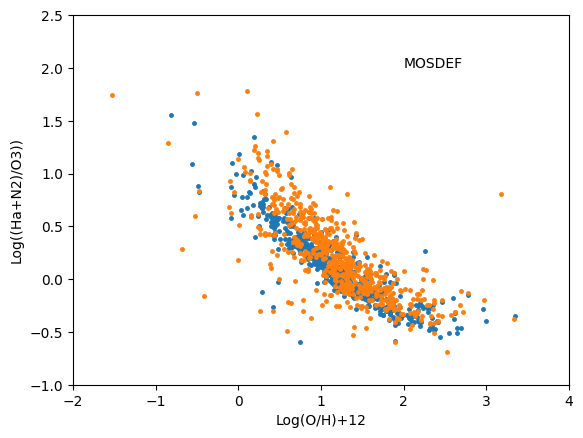

In [267]:
## MOSDEF plot

Halpha_MOS_int 
OIII_MOS_int
NII_MOS_int 

# D16
logOH_Dop16_MOS_cor
logOH_Dop16_MOS_unc
## O3N2
O3N2_MOS_unc = np.log10((OIII5008_MOSDEF/Hb_MOSDEF) / (NII85_MOSDEF / Ha_MOSDEF))
O3N2_MOS_cor = np.log10((OIII5008_MOS_int/Hbeta_MOS_int) / (NII85_MOS_int / Halpha_MOS_int))

HaN2_O3_MOS_cor = np.log10((NII_MOS_int  + Halpha_MOS_int ) / OIII_MOS_int)
HaN2_O3_MOS_unc = np.log10((NII_MOSDEF  + Ha_MOSDEF ) / OIII_MOSDEF)

#plt.plot(logOH_Dop16_MOS_cor, HaN2_O3_MOS_cor, '.', markersize = 5)
#plt.plot(logOH_Dop16_MOS_unc, HaN2_O3_MOS_unc, '.', markersize = 5)
plt.plot(O3N2_MOS_cor, HaN2_O3_MOS_cor, '.', markersize = 5)
plt.plot(O3N2_MOS_unc, HaN2_O3_MOS_unc, '.', markersize = 5)
plt.xlim(-2,4)
plt.ylim(-1,2.5)
plt.text(2,2, 'MOSDEF')
plt.xlabel('Log(O/H)+12')
plt.ylabel('Log((Ha+N2)/O3))')
plt.show()



Final Trend: Ha+NII/O3 plots

/tmp/ipykernel_4004564/3804897570.py:10: RuntimeWarning: invalid value encountered in log10
  HaN2_O3_cor = np.log10((NII_Batt_int + Halpha_Batt_int) / OIII_Batt_int)


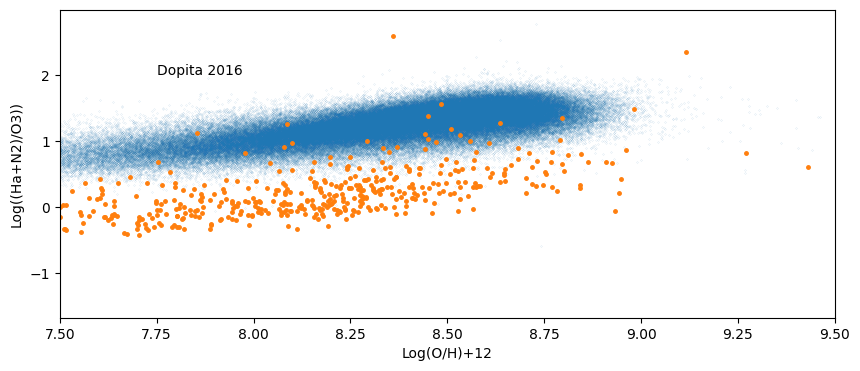

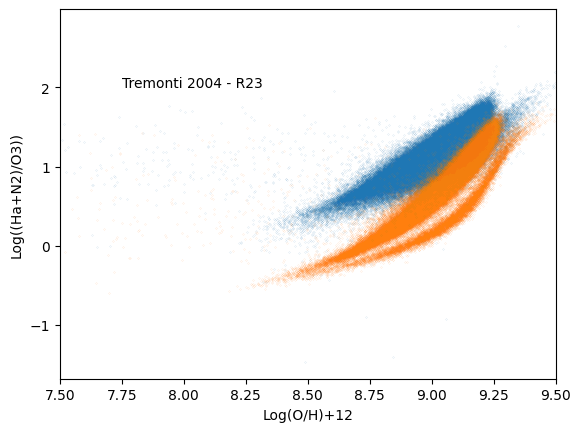

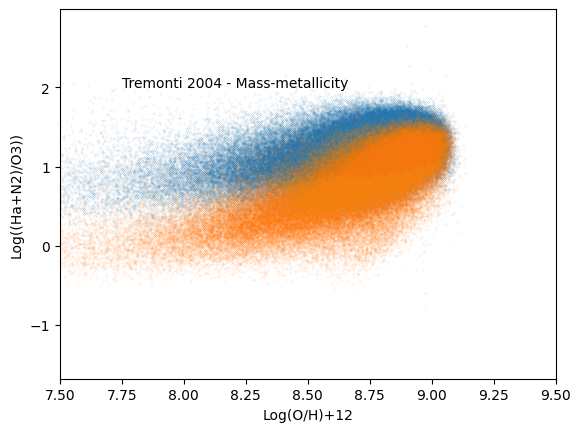

Spearman, uncorrected: 0.9338299754020288
Spearman, corrected: 0.7733451758179499


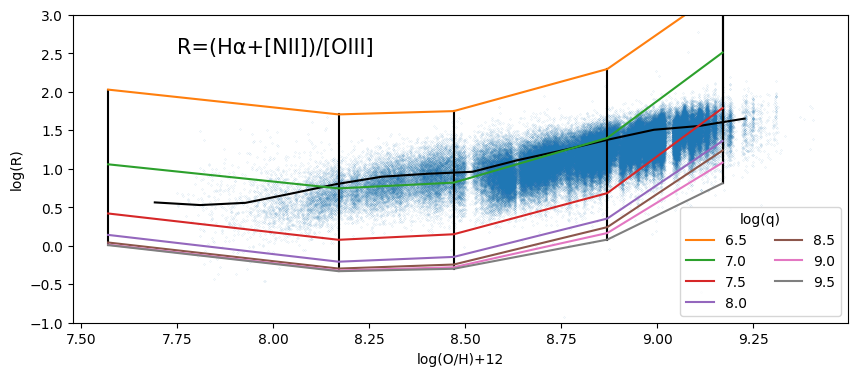

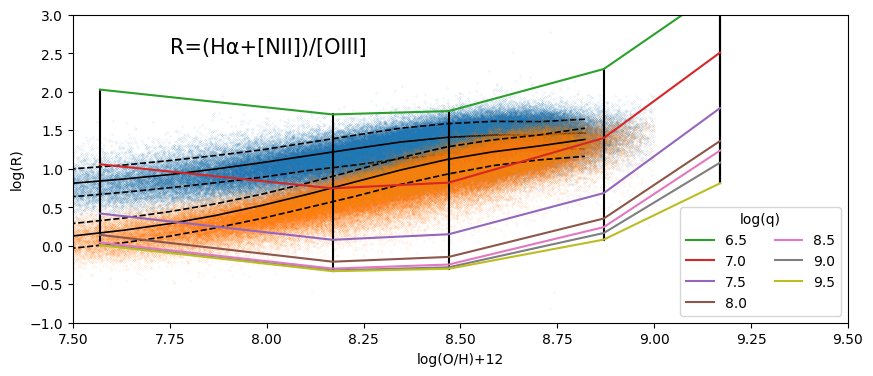

Spearman, uncorrected: 0.8987990989349894
Spearman, corrected: 0.7026010096633981


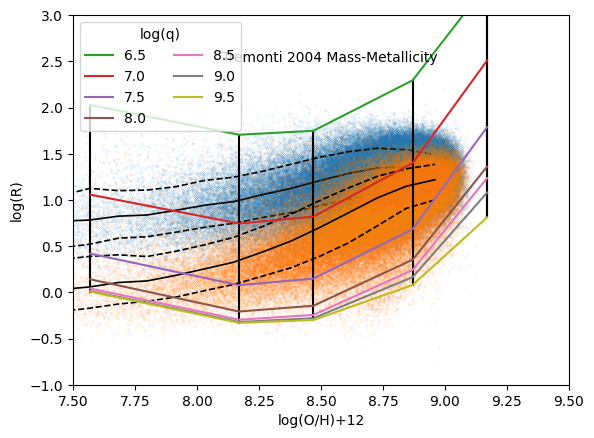

Spearman, uncorrected: 0.7065925747107381
Spearman, corrected: 0.43686259625990703


In [269]:
## Ha+NII / O3 plots!!

####
# ratio of emission lines
####
# uses doublets 
# uncorrected
HaN2_O3_unc = np.log10((NII_Batt + Halpha_Batt) / OIII_Batt)
# corrected
HaN2_O3_cor = np.log10((NII_Batt_int + Halpha_Batt_int) / OIII_Batt_int)

####
# metallicity
####
## Dopita 2016
# corrected
#logOH_Dop16
# uncorrected
#logOH_Dop16_unc
## Tremonti 2004
# mass - metallicity
# calculated
#logOH_Tre04
# from SDSS
#logOH_p50_Batt
# r23
#corrected
#tre_r23_cor
# uncorrected
#tre_r23_unc
# Metallicities 
dop_int = logOH_Dop16
dop_unc = logOH_Dop16_unc
# SDSS metallicity
tre_sdss = logOH_p50
# tre mass calculate
tre_calc = logOH_Tre04

plt.figure(figsize=(10,4))
plt.plot(dop_int, HaN2_O3_cor, '.', markersize = 0.11)
#plt.plot(dop_unc, HaN2_O3_unc, '.', markersize = 0.11)
plt.plot(logOH_Dop16_MOS_cor, HaN2_O3_MOS_cor, '.', markersize = 5)
#plt.plot(logOH_Dop16_MOS_unc, HaN2_O3_MOS_unc, '.', markersize = 5)
plt.xlim(7.5,9.5)
plt.text(7.75,2, 'Dopita 2016')
plt.xlabel('Log(O/H)+12')
plt.ylabel('Log((Ha+N2)/O3))')
plt.show()

plt.plot(tre_r23_cor, HaN2_O3_cor, '.', markersize = 0.11)
plt.plot(tre_r23_unc, HaN2_O3_unc, '.', markersize = 0.11)
plt.xlim(7.5,9.5)
plt.text(7.75,2, 'Tremonti 2004 - R23')
plt.xlabel('Log(O/H)+12')
plt.ylabel('Log((Ha+N2)/O3))')
plt.show()

plt.plot(tre_calc, HaN2_O3_cor, '.', markersize = 0.11)
plt.plot(tre_calc, HaN2_O3_unc, '.', markersize = 0.11)
plt.xlim(7.5,9.5)
plt.text(7.75,2, 'Tremonti 2004 - Mass-metallicity')
plt.xlabel('Log(O/H)+12')
plt.ylabel('Log((Ha+N2)/O3))')
plt.show()


## Subplots that show ratio, dust and undust, each subplot is a metallicity diag:
# tre 04 mass
# tre 04 r23
# dop 16


### Tremonti 2004 from SDSS
# corrected 
plt.figure(figsize=(10,4))
w = np.where((tre_sdss > 7.75) & (HaN2_O3_cor > -5)& (HaN2_O3_cor < 5)&(np.isnan(HaN2_O3_cor) ==False))[0] 
plt.plot(tre_sdss[w], HaN2_O3_cor[w], '.', markersize = 0.11)
HaN2_O3_cor1 = HaN2_O3_cor[w]
tre_sdsscor = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_cor1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.5)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((tre_sdss > 7.75) & (HaN2_O3_unc > -5)& (HaN2_O3_unc < 5))[0] 
#plt.plot(tre_sdss[w], HaN2_O3_unc[w], '.', markersize = 0.11)
HaN2_O3_unc1 = HaN2_O3_unc[w]
tre_sdssunc = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_unc1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_unc1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_unc1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
#plt.plot(x, median, 'k-', linewidth=1.5)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
## model
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')
plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')#, label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2, title="log(q)")
#plt.legend(handles=[lab1,lab2],loc='lower right')
plt.text(7.75,2.5,'R=(H\u03B1+[NII])/[OIII]',fontsize=15)
plt.ylim(-1,3)
plt.xlabel('log(O/H)+12')
plt.ylabel('log(R)')
#plt.savefig("HbHaN2_O3.dustcomp.7.22.pdf",format="pdf")
#plt.show()

## Spearman correlation
HaN2_O3_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, HaN2_O3_unc1)
print('Spearman, uncorrected:',HaN2_O3_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_O3_cor_spearman, p_value = stats.spearmanr(tre_sdsscor, HaN2_O3_cor1)
print('Spearman, corrected:',HaN2_O3_cor_spearman)

### Dopita 2016
# corrected 
plt.figure(figsize=(10,4))
w = np.where((dop_int > 6.5)& (dop_int <9 )& (HaN2_O3_cor > -5)& (HaN2_O3_cor < 5)&(np.isnan(HaN2_O3_cor) ==False))[0] 
plt.plot(dop_int[w], HaN2_O3_cor[w], '.', markersize = 0.11)
HaN2_O3_cor1 = HaN2_O3_cor[w]
dop_int1 = dop_int[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(dop_int[w]) - min(dop_int[w])) / binwidth)
bins = np.linspace(min(dop_int[w]), max(dop_int[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(dop_int[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_cor1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((dop_unc > 6.5)&(dop_unc <9 ) & (HaN2_O3_unc > -5)& (HaN2_O3_unc < 5))[0] 
plt.plot(dop_unc[w], HaN2_O3_unc[w], '.', markersize = 0.11)
HaN2_O3_unc1 = HaN2_O3_unc[w]
dop_unc1 = dop_unc[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(dop_unc[w]) - min(dop_unc[w])) / binwidth)
bins = np.linspace(min(dop_unc[w]), max(dop_unc[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(dop_unc[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_unc1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_unc1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_unc1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
## model
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')
plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')#, label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2, title="log(q)")
#plt.legend(handles=[lab1,lab2],loc='lower right')
#plt.text(6.5,2,'R=(Ha+N2)/O3')
#plt.text(7.6,2.5,'Dopita 2016')
plt.text(7.75,2.5,'R=(H\u03B1+[NII])/[OIII]',fontsize=15)
plt.ylim(-1,3)
plt.xlim(7.5,9.5)
plt.xlabel('log(O/H)+12')
plt.ylabel('log(R)')
#plt.savefig("HbHaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HaN2_O3_unc_spearman, p_value = stats.spearmanr(dop_unc1, HaN2_O3_unc1)
print('Spearman, uncorrected:',HaN2_O3_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_O3_cor_spearman, p_value = stats.spearmanr(dop_int1, HaN2_O3_cor1)
print('Spearman, corrected:',HaN2_O3_cor_spearman)

### Tremonti mass calculation
# corrected 
w = np.where((tre_calc > 6.5)& (tre_calc <11 )& (HaN2_O3_cor > -5)& (HaN2_O3_cor < 5)&(np.isnan(HaN2_O3_cor) ==False))[0] 
plt.plot(tre_calc[w], HaN2_O3_cor[w], '.', markersize = 0.11)
HaN2_O3_cor1 = HaN2_O3_cor[w]
tre_calccor = tre_calc[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_calc[w]) - min(tre_calc[w])) / binwidth)
bins = np.linspace(min(tre_calc[w]), max(tre_calc[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_calc[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_cor1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((tre_calc > 6.5)&(tre_calc <11 ) & (HaN2_O3_unc > -5)& (HaN2_O3_unc < 5))[0] 
plt.plot(tre_calc[w], HaN2_O3_unc[w], '.', markersize = 0.11)
HaN2_O3_unc1 = HaN2_O3_unc[w]
tre_calcunc = tre_calc[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.11
total_bins = int((max(tre_calc[w]) - min(tre_calc[w])) / binwidth)
bins = np.linspace(min(tre_calc[w]), max(tre_calc[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_calc[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_unc1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_unc1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_unc1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.2)
plt.plot(x, perc1, 'k--', linewidth=1.2)
plt.plot(x, perc2, 'k--', linewidth=1.2)
## model
for i in range(len(Zlist)):
    w = np.where((metal_model == Zlist[i]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')
plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')#, label='Age=1Myr')
    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2, title="log(q)")
#plt.legend(handles=[lab1,lab2],loc='lower right')
#plt.text(6.5,2,'R=(Ha+N2)/O3')
plt.text(8.1,2.5,'Tremonti 2004 Mass-Metallicity')
plt.ylim(-1,3)
plt.xlim(7.5,9.5)
plt.xlabel('log(O/H)+12')
plt.ylabel('log(R)')
#plt.savefig("HbHaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HaN2_O3_unc_spearman, p_value = stats.spearmanr(tre_calcunc, HaN2_O3_unc1)
print('Spearman, uncorrected:',HaN2_O3_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_O3_cor_spearman, p_value = stats.spearmanr(tre_calccor, HaN2_O3_cor1)
print('Spearman, corrected:',HaN2_O3_cor_spearman)





Surface Fitting E(B-V)

In [ ]:
# Try surface fitting

# Create grid of E(B-V)
# need to iterate every value of EB_Vgrid over every value of uncorrected halpha_batt
EB_Vgrid = np.arange(-0.4,1.2,0.1)
print(EB_Vgrid)
print(Halpha_Batt)

#for i in EB_Vgrid:
#Halpha_Batt_ebv = (pow(10,0.4*k_Ha*EB_Vgrid))*Halpha_Batt

Halpha_Batt_ebv = np.outer((pow(10,0.4*k_Ha*EB_Vgrid)), Halpha_Batt)
#print(Halpha_Batt_ebv[5])
print(len(Halpha_Batt_ebv))

OIII5007_Batt_ebv = np.outer((pow(10,0.4*k_OIII5007*EB_Vgrid)),OIII5007_Batt)
OIII4959Batt_ebv = np.outer((pow(10,0.4*k_OIII4959*EB_Vgrid)),OIII4959_Batt)
OIII_Batt_ebv = OIII5007_Batt_ebv + OIII4959Batt_ebv
NII84_Batt_ebv = np.outer((pow(10,0.4*k_NII84*EB_Vgrid)),NII84_Batt)
NII48_Batt_ebv = np.outer((pow(10,0.4*k_NII48*EB_Vgrid)),NII48_Batt)
NII_Batt_ebv = NII84_Batt_ebv + NII48_Batt_ebv

HaN2_O3ebv = (Halpha_Batt_ebv + NII_Batt_ebv)/OIII_Batt_ebv


#w = np.where(EB_Vgrid == 0.5)[0]
#plt.plot(tre_sdss[w], HaN2_O3ebv[w], '.', c='k')
#plt.xlim(7,10)
#plt.ylim(-2,3)
#plt.show()

EB_Vgrid = np.arange(-2,2,0.1)
print(EB_Vgrid[4])
for i in range(len(EB_Vgrid)):
    # calculate intrinsic fluxes
    Halpha_Batt_ebv = (pow(10,0.4*k_Ha*EB_Vgrid[i]))*Halpha_Batt
    OIII5007_Batt_ebv = (pow(10,0.4*k_OIII5007*EB_Vgrid[i]))*OIII5007_Batt
    OIII4959Batt_ebv = (pow(10,0.4*k_OIII4959*EB_Vgrid[i]))*OIII4959_Batt
    OIII_Batt_ebv = OIII5007_Batt_ebv + OIII4959Batt_ebv
    NII84_Batt_ebv = (pow(10,0.4*k_NII84*EB_Vgrid[i]))*NII84_Batt
    NII48_Batt_ebv = (pow(10,0.4*k_NII48*EB_Vgrid[i]))*NII48_Batt
    NII_Batt_ebv = NII84_Batt_ebv + NII48_Batt_ebv
    # calculate ratio
    HaN2_O3ebv = np.log10((Halpha_Batt_ebv + NII_Batt_ebv)/OIII_Batt_ebv)
    #plt.plot(tre_sdss, HaN2_O3ebv, '.',markersize=.1)
    # median calculation
    binwidth = 0.1
    total_bins = int((max(tre_sdss) - min(tre_sdss)) / binwidth)
    bins = np.linspace(min(tre_sdss), max(tre_sdss), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(tre_sdss, bins)
    #print(max(O3_HaN2_cor[idx==8]), idx)
    median = [np.percentile(HaN2_O3ebv[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3ebv[idx==k+1]) > 4]
    perc1 = [np.percentile(HaN2_O3ebv[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3ebv[idx==k+1]) > 4]
    perc2 = [np.percentile(HaN2_O3ebv[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3ebv[idx==k+1]) > 4]
    x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3ebv[idx==k+1]) > 4]
    plt.plot(x, median, linewidth=1.2, label=[i])
    #plt.plot(x, perc1, 'k--', linewidth=1.2)
    #plt.plot(x, perc2, 'k--', linewidth=1.2)
    #plt.legend()
plt.plot(tre_sdss, HaN2_O3_Batt_int, '.',markersize=.1,label='corrected')
plt.plot(tre_sdss, HaN2_O3_Batt, '.',markersize=.1,label='uncorrected')
#plt.legend(handles=[lab1,lab2],loc='lower right')
plt.xlim(7.5,9.5)
plt.ylim(-1,2)
plt.xlabel('logOH')
plt.ylabel('log(Ha+N2/O3)')
plt.show()




'''

plt.plot(metal_model[w], HaN2_O3_model[w], '-', c='k')#, label='Age=1Myr')

    
for j in range(len(Qlist)):
    w = np.where((logQ_model==Qlist[j]) & (stellarage_model==1))[0]
    plt.plot(metal_model[w], HaN2_O3_model[w], '-',label=Qlist_names[j])
    plt.legend(ncols=2, title="log(q)")


# input variables, a set of arrays. I assume the uncorrected flux ratio, and E(B-V)?
# should metallicity be here too?  
x = np.array([HaN2_O3_unc,EB_V])
# transpose so each variable is a column
#print(x.T)

# Generate polynomial features of desired degree
d = 3
poly = PolynomialFeatures(degree=d, include_bias=False)
X = poly.fit_transform(x.T[:, :-1])
print(X)
# 
y = x.T[:,-1]

# Define and fit linear regression 
clf = LinearRegression()
clf.fit(X, y)

# Check results
print(clf.coef_)

print(clf.intercept_)

y = 0.124807*(X**2)  +  0.11924269*X -0.00478007

plt.plot(X,y,'.',markersize=1)
#plt.legend()
plt.show()
'''